In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019/valid.csv
/kaggle/input/aptos2019/test.csv
/kaggle/input/aptos2019/train_1.csv
/kaggle/input/aptos2019/val_images/val_images/17f6c7072f61.png
/kaggle/input/aptos2019/val_images/val_images/0243404e8a00.png
/kaggle/input/aptos2019/val_images/val_images/0083ee8054ee.png
/kaggle/input/aptos2019/val_images/val_images/0ac436400db4.png
/kaggle/input/aptos2019/val_images/val_images/0d0a21fd354f.png
/kaggle/input/aptos2019/val_images/val_images/02da652c74b8.png
/kaggle/input/aptos2019/val_images/val_images/15e96e848b46.png
/kaggle/input/aptos2019/val_images/val_images/059bc89df7f4.png
/kaggle/input/aptos2019/val_images/val_images/04d029cfb612.png
/kaggle/input/aptos2019/val_images/val_images/08752092140d.png
/kaggle/input/aptos2019/val_images/val_images/0ef4c61dc056.png
/kaggle/input/aptos2019/val_images/val_images/1a7e3356b39c.png
/kaggle/input/aptos2019/val_images/val_images/06be1092a062.png
/kaggle/input/aptos2019/val_images/val_images/03a7f4a5786f.png
/kaggle/input/a

In [ ]:
        BASE_PATH = '/kaggle/input/aptos2019/'
        train_csv_path = os.path.join(BASE_PATH, 'train_1.csv')
        val_csv_path = os.path.join(BASE_PATH, 'valid.csv')
        train_img_dir = os.path.join(BASE_PATH, 'train_images', 'train_images')
        val_img_dir = os.path.join(BASE_PATH, 'val_images', 'val_images')

        # Load dataframes using the provided train/validation split
        train_df = pd.read_csv(train_csv_path)
        val_df = pd.read_csv(val_csv_path)
        train_df['diagnosis'].value_counts()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import gc
import os
import timm
import cv2

# =============================================================================
# DATASET CLASS
# =============================================================================

class DiabeticRetinopathyDataset(Dataset):
    """Custom Dataset for Diabetic Retinopathy images."""
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx]['id_code'] + '.png')
        image = Image.open(img_name).convert('RGB')
        label = torch.tensor(self.dataframe.iloc[idx]['diagnosis'], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


# =============================================================================
# ADVANCED PREPROCESSING TRANSFORM
# =============================================================================

class AdvancedBenGrahamPreprocess(object):
    """Applies a series of robust preprocessing steps for fundus images."""
    def __init__(self, output_size=256):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        # Convert PIL image to numpy array
        img_np = np.array(image)

        # 1. Crop black borders
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            img_np = img_np[y:y+h, x:x+w]

        # 2. Apply CLAHE to the green channel for contrast enhancement
        b, g, r = cv2.split(img_np)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        g = clahe.apply(g)
        img_clahe = cv2.merge((b, g, r))

        # 3. Apply a gentle Gaussian blur to reduce noise
        img_blur = cv2.GaussianBlur(img_clahe, (5, 5), 0)

        # 4. Resize to target size
        img_resized = cv2.resize(img_blur, self.output_size, interpolation=cv2.INTER_AREA)
        
        # Convert back to PIL Image
        return Image.fromarray(img_resized)


# =============================================================================
# LOSS FUNCTIONS
# =============================================================================

class OrdinalCrossEntropyLoss(nn.Module):
    """Cross Entropy Loss for Ordinal Regression."""
    def __init__(self, num_classes=5, class_weights=None):
        super(OrdinalCrossEntropyLoss, self).__init__()
        self.num_classes = num_classes
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        self.class_weights = class_weights

    def forward(self, outputs, targets):
        """
        outputs: (batch_size, num_classes-1) ordinal logits
        targets: (batch_size,) class labels 0 to num_classes-1
        """
        # Create ordinal targets
        ordinal_targets = torch.zeros_like(outputs)
        for i, target in enumerate(targets):
            if target > 0:
                ordinal_targets[i, :target] = 1.0

        losses = self.bce_loss(outputs, ordinal_targets)

        if self.class_weights is not None:
            weights = self.class_weights[targets]
            return (losses.mean(dim=1) * weights).mean()
        else:
            return losses.mean()

class SmoothKappaLoss(nn.Module):
    """Smooth Quadratic Weighted Kappa Loss for Ordinal Regression."""
    def __init__(self, num_classes=5):
        super(SmoothKappaLoss, self).__init__()
        self.num_classes = num_classes

        # Create quadratic weight matrix
        weight_matrix = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes):
                weight_matrix[i, j] = (i - j) ** 2
        self.register_buffer('weight_matrix', weight_matrix)

    def forward(self, outputs, targets):
        """
        outputs: (batch_size, num_classes-1) ordinal logits
        targets: (batch_size,) class labels
        """
        batch_size = outputs.size(0)

        # Convert ordinal outputs to class probabilities
        probs = torch.sigmoid(outputs)
        class_probs = torch.zeros(batch_size, self.num_classes, device=outputs.device)
        class_probs[:, 0] = 1 - probs[:, 0]
        for k in range(1, self.num_classes - 1):
            class_probs[:, k] = probs[:, k-1] - probs[:, k]
        class_probs[:, -1] = probs[:, -1]

        # Ensure probabilities are valid and sum to 1
        class_probs = torch.clamp(class_probs, min=1e-7, max=1.0)
        class_probs = class_probs / class_probs.sum(dim=1, keepdim=True)

        # One-hot encode targets
        one_hot_targets = F.one_hot(targets, num_classes=self.num_classes).float()

        # Calculate observed agreement
        observed_agreement = torch.sum(one_hot_targets * class_probs * self.weight_matrix[targets, :])

        # Calculate expected agreement
        true_marginals = one_hot_targets.sum(dim=0)
        pred_marginals = class_probs.sum(dim=0)
        expected_outer = torch.outer(true_marginals, pred_marginals)
        expected_agreement = torch.sum(expected_outer * self.weight_matrix)

        # QWK is 1 - (observed / expected), so loss is observed / (expected + epsilon)
        loss = observed_agreement / (expected_agreement + 1e-7)
        return loss

# =============================================================================
# MODEL
# =============================================================================

class EfficientNetOrdinal(nn.Module):
    """EfficientNet for Ordinal Regression."""
    def __init__(self, model_name='efficientnet_b2', num_classes=5, pretrained=True):
        super(EfficientNetOrdinal, self).__init__()
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,  # Remove classification head
            global_pool='avg'
        )
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes - 1)
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def ordinal_to_class(outputs):
    """Convert ordinal outputs to class predictions."""
    probs = torch.sigmoid(outputs)
    return torch.sum(probs > 0.5, dim=1).long()

def calculate_metrics(outputs, targets):
    """Calculate accuracy, QWK, and within-1 accuracy."""
    preds = ordinal_to_class(outputs).cpu().numpy()
    targets_np = targets.cpu().numpy()
    accuracy = accuracy_score(targets_np, preds)
    qwk = cohen_kappa_score(targets_np, preds, weights='quadratic')
    within1 = np.mean(np.abs(targets_np - preds) <= 1)
    return accuracy, qwk, within1

def clear_memory():
    """Clear GPU memory."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# =============================================================================
# TRAINING & VALIDATION LOOPS
# =============================================================================

def train_epoch(model, train_loader, optimizer, criterion, scaler, device):
    """Train one epoch."""
    model.train()
    running_loss = 0.0
    all_outputs, all_targets = [], []

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        all_outputs.append(outputs.detach())
        all_targets.append(targets.detach())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    accuracy, qwk, within1 = calculate_metrics(all_outputs, all_targets)
    return running_loss / len(train_loader), accuracy, qwk, within1

def validate_epoch(model, val_loader, criterion, device):
    """Validate one epoch."""
    model.eval()
    running_loss = 0.0
    all_outputs, all_targets = [], []

    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            all_outputs.append(outputs)
            all_targets.append(targets)

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    accuracy, qwk, within1 = calculate_metrics(all_outputs, all_targets)
    return running_loss / len(val_loader), accuracy, qwk, within1

# =============================================================================
# MAIN TRAINING PIPELINE
# =============================================================================

def main_training_pipeline(train_loader, val_loader, train_df, device):
    """Complete 2-stage training pipeline."""
    print("--> STARTING ORDINAL REGRESSION TRAINING")
    print("=" * 60)

    # MODEL AND LOSSES
    model = EfficientNetOrdinal('efficientnet_b2', num_classes=5).to(device)
    print(f"[INFO] Model created: EfficientNet-B2 with ordinal head")

    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
    class_weights = torch.FloatTensor(class_weights).to(device)
    print(f"Class weights: {class_weights.cpu().numpy().round(2)}")

    ce_loss = OrdinalCrossEntropyLoss(num_classes=5, class_weights=class_weights)
    kappa_loss = SmoothKappaLoss(num_classes=5)
    scaler = torch.amp.GradScaler('cuda')

 #   # STAGE 1: CROSS ENTROPY TRAINING
 #   print("\n--> STAGE 1: CROSS ENTROPY TRAINING (30 EPOCHS)")
  #  print("=" * 60)
  #  optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
 #   scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
  #  best_qwk_stage1 = 0
  #  patience, patience_counter = 10, 0

  #  for epoch in range(30):
   #     clear_memory()
  #      train_loss, train_acc, train_qwk, train_within1 = train_epoch(model, train_loader, optimizer, ce_loss, scaler, device)
   #     val_loss, val_acc, val_qwk, val_within1 = validate_epoch(model, val_loader, ce_loss, device)
  #      scheduler.step()

   #     print(f"Epoch {epoch+1}/30:")
   #     print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, QWK={train_qwk:.4f}, \u00b11={train_within1:.4f}")
   #     print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.4f}, QWK={val_qwk:.4f}, \u00b11={val_within1:.4f}")

   #     if val_qwk > best_qwk_stage1:
     #       best_qwk_stage1 = val_qwk
     #       torch.save(model.state_dict(), 'best_model_stage1.pth')
     #       patience_counter = 0
     #       print(f"  [SAVE] New best QWK: {best_qwk_stage1:.4f}. Model saved!")
    #    else:
     #       patience_counter += 1

     #   if patience_counter >= patience:
       #     print(f"Early stopping at epoch {epoch+1}")
     #       break

    print(f"\n[INFO] Stage 1 completed! Best QWK: {0.9051}")
    model.load_state_dict(torch.load('best_model_stage1.pth'))

    # STAGE 2: KAPPA LOSS FINE-TUNING
    print("\n--> STAGE 2: KAPPA LOSS FINE-TUNING (30 EPOCHS)")
    print("=" * 60)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
    best_qwk_stage2 = 0.9051
    patience_counter = 0

    for epoch in range(30):
        clear_memory()
        train_loss, train_acc, train_qwk, train_within1 = train_epoch(model, train_loader, optimizer, kappa_loss, scaler, device)
        val_loss, val_acc, val_qwk, val_within1 = validate_epoch(model, val_loader, kappa_loss, device)
        scheduler.step()

        print(f"Epoch {epoch+1}/30:")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, QWK={train_qwk:.4f}, \u00b11={train_within1:.4f}")
        print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.4f}, QWK={val_qwk:.4f}, \u00b11={val_within1:.4f}")

        if val_qwk > best_qwk_stage2:
            best_qwk_stage2 = val_qwk
            torch.save(model.state_dict(), 'best_model_final.pth')
            patience_counter = 0
            print(f"  [SAVE] New best QWK: {best_qwk_stage2:.4f}. Model saved!")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"\n--> TRAINING COMPLETED!")
    print("=" * 60)
    print(f"Stage 1 Best QWK: {best_qwk_stage1:.4f}")
    print(f"Stage 2 Best QWK: {best_qwk_stage2:.4f}")
    print(f"Improvement: {best_qwk_stage2 - best_qwk_stage1:.4f}")

    model.load_state_dict(torch.load('best_model_final.pth'))
    return model

# =============================================================================
# RUN TRAINING
# =============================================================================

if __name__ == "__main__":
    # --- CONFIGURATION ---
    IMG_SIZE = 256
    BATCH_SIZE = 16
    NUM_WORKERS = 2 # On Kaggle, 2 is often a good choice

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Enable memory management for PyTorch
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

    # --- DATA PREPARATION ---
    # This is an example. Replace with your actual data paths and dataframe loading.
    # On Kaggle, paths are typically like '/kaggle/input/aptos2019-blindness-detection/'

    try:
        # Define paths based on the screenshot
        BASE_PATH = '/kaggle/input/aptos2019/'
        train_csv_path = os.path.join(BASE_PATH, 'train_1.csv')
        val_csv_path = os.path.join(BASE_PATH, 'valid.csv')
        train_img_dir = os.path.join(BASE_PATH, 'train_images', 'train_images')
        val_img_dir = os.path.join(BASE_PATH, 'val_images', 'val_images')

        # Load dataframes using the provided train/validation split
        train_df = pd.read_csv(train_csv_path)
        val_df = pd.read_csv(val_csv_path)

        print(f"Training data: {len(train_df)} samples")
        print(f"Validation data: {len(val_df)} samples")
        print(f"Class distribution in training:\n{train_df['diagnosis'].value_counts().sort_index()}")

        # --- DATA AUGMENTATION & LOADERS ---
        train_transforms = transforms.Compose([
            AdvancedBenGrahamPreprocess(output_size=IMG_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        val_transforms = transforms.Compose([
            AdvancedBenGrahamPreprocess(output_size=IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Create separate datasets for training and validation
        train_dataset = DiabeticRetinopathyDataset(train_df, train_img_dir, transform=train_transforms)
        val_dataset = DiabeticRetinopathyDataset(val_df, val_img_dir, transform=val_transforms)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

        # --- RUN TRAINING ---
        final_model = main_training_pipeline(train_loader, val_loader, train_df, device)

        print("\n[SUCCESS] Training pipeline completed successfully!")
        print("Models saved:")
        print(" - best_model_stage1.pth (after cross-entropy training)")
        print(" - best_model_final.pth (after kappa loss fine-tuning)")

    except Exception as e:
        print(f"An error occurred: {e}")
        print("[NOTE] Please ensure your data paths are correct and you have run this in an environment with the data.")

    print("[INFO] To run the training, uncomment the code block in `if __name__ == '__main__':`")
    print("1. Set your BASE_PATH to the correct data directory.")
    print("2. Ensure your CSV file has 'id_code' and 'diagnosis' columns.")
    print("3. Run the script.")


In [ ]:
import os

print(os.listdir("/kaggle/working"))   # check working directory
with open("/kaggle/working/") as f:
    data = f.read()
    print(data[:200])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import gc
import os
import timm
import cv2

# =============================================================================
# DATASET CLASS
# =============================================================================

class DiabeticRetinopathyDataset(Dataset):
    """Custom Dataset for Diabetic Retinopathy images."""
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx]['id_code'] + '.png')
        image = Image.open(img_name).convert('RGB')
        label = torch.tensor(self.dataframe.iloc[idx]['diagnosis'], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


# =============================================================================
# ADVANCED PREPROCESSING TRANSFORM
# =============================================================================

class AdvancedBenGrahamPreprocess(object):
    """Applies a series of robust preprocessing steps for fundus images."""
    def __init__(self, output_size=256):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        # Convert PIL image to numpy array
        img_np = np.array(image)

        # 1. Crop black borders
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            img_np = img_np[y:y+h, x:x+w]

        # 2. Apply CLAHE to the green channel for contrast enhancement
        b, g, r = cv2.split(img_np)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        g = clahe.apply(g)
        img_clahe = cv2.merge((b, g, r))

        # 3. Apply a gentle Gaussian blur to reduce noise
        img_blur = cv2.GaussianBlur(img_clahe, (5, 5), 0)

        # 4. Resize to target size
        img_resized = cv2.resize(img_blur, self.output_size, interpolation=cv2.INTER_AREA)
        
        # Convert back to PIL Image
        return Image.fromarray(img_resized)


# =============================================================================
# LOSS FUNCTIONS
# =============================================================================

class OrdinalCrossEntropyLoss(nn.Module):
    """Cross Entropy Loss for Ordinal Regression."""
    def __init__(self, num_classes=5, class_weights=None):
        super(OrdinalCrossEntropyLoss, self).__init__()
        self.num_classes = num_classes
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        self.class_weights = class_weights

    def forward(self, outputs, targets):
        """
        outputs: (batch_size, num_classes-1) ordinal logits
        targets: (batch_size,) class labels 0 to num_classes-1
        """
        # Create ordinal targets
        ordinal_targets = torch.zeros_like(outputs)
        for i, target in enumerate(targets):
            if target > 0:
                ordinal_targets[i, :target] = 1.0

        losses = self.bce_loss(outputs, ordinal_targets)

        if self.class_weights is not None:
            weights = self.class_weights[targets]
            return (losses.mean(dim=1) * weights).mean()
        else:
            return losses.mean()

import torch
import torch.nn as nn
import torch.nn.functional as F

class SmoothKappaLoss(nn.Module):
    """
    Differentiable approximation of Quadratic Weighted Kappa (QWK) loss.
    Works with ordinal regression outputs (num_classes - 1 logits).
    """
    def __init__(self, num_classes=5, eps=1e-7):
        super(SmoothKappaLoss, self).__init__()
        self.num_classes = num_classes
        self.eps = eps

        # Precompute quadratic weights (normalized)
        W = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes):
                W[i, j] = ((i - j) ** 2) / ((num_classes - 1) ** 2)
        self.register_buffer("W", W)  # buffer ensures same device as model

    def forward(self, outputs, targets):
        """
        outputs: (batch_size, num_classes-1) ordinal logits
        targets: (batch_size,) ground-truth labels
        """
        device = outputs.device
        B = outputs.size(0)

        # Convert ordinal outputs -> class probabilities
        probs = torch.sigmoid(outputs)
        class_probs = torch.zeros(B, self.num_classes, device=device)
        class_probs[:, 0] = 1 - probs[:, 0]
        for k in range(1, self.num_classes - 1):
            class_probs[:, k] = probs[:, k - 1] - probs[:, k]
        class_probs[:, -1] = probs[:, -1]

        class_probs = torch.clamp(class_probs, min=self.eps, max=1.0)
        class_probs = class_probs / class_probs.sum(dim=1, keepdim=True)

        # One-hot encode targets (make sure it's on the same device)
        one_hot = F.one_hot(targets, num_classes=self.num_classes).float().to(device)

        # Confusion matrix (soft)
        conf_mat = torch.matmul(one_hot.T, class_probs)
        conf_mat = conf_mat / (conf_mat.sum() + self.eps)

        # Expected agreement
        hist_true = one_hot.sum(dim=0)
        hist_pred = class_probs.sum(dim=0)
        expected = torch.outer(hist_true, hist_pred)
        expected = expected / (expected.sum() + self.eps)

        # Weighted observed & expected
        W = self.W.to(device)  # ✅ force on same device
        obs = torch.sum(W * conf_mat)
        exp = torch.sum(W * expected)

        # Quadratic Kappa
        kappa = 1.0 - obs / (exp + self.eps)

        # Loss (want to maximize kappa, so minimize 1 - kappa)
        return 1.0 - kappa



# =============================================================================
# MODEL
# =============================================================================

class EfficientNetOrdinal(nn.Module):
    """EfficientNet for Ordinal Regression."""
    def __init__(self, model_name='efficientnet_b2', num_classes=5, pretrained=True):
        super(EfficientNetOrdinal, self).__init__()
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,  # Remove classification head
            global_pool='avg'
        )
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes - 1)
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def ordinal_to_class(outputs):
    """Convert ordinal outputs to class predictions."""
    probs = torch.sigmoid(outputs)
    return torch.sum(probs > 0.5, dim=1).long()

def calculate_metrics(outputs, targets):
    """Calculate accuracy, QWK, and within-1 accuracy."""
    preds = ordinal_to_class(outputs).cpu().numpy()
    targets_np = targets.cpu().numpy()
    accuracy = accuracy_score(targets_np, preds)
    qwk = cohen_kappa_score(targets_np, preds, weights='quadratic')
    within1 = np.mean(np.abs(targets_np - preds) <= 1)
    return accuracy, qwk, within1

def clear_memory():
    """Clear GPU memory."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# =============================================================================
# TRAINING & VALIDATION LOOPS
# =============================================================================

def train_epoch(model, train_loader, optimizer, criterion, scaler, device):
    """Train one epoch."""
    model.train()
    running_loss = 0.0
    all_outputs, all_targets = [], []

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        all_outputs.append(outputs.detach())
        all_targets.append(targets.detach())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    accuracy, qwk, within1 = calculate_metrics(all_outputs, all_targets)
    return running_loss / len(train_loader), accuracy, qwk, within1

def validate_epoch(model, val_loader, criterion, device):
    """Validate one epoch."""
    model.eval()
    running_loss = 0.0
    all_outputs, all_targets = [], []

    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            all_outputs.append(outputs)
            all_targets.append(targets)

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    accuracy, qwk, within1 = calculate_metrics(all_outputs, all_targets)
    return running_loss / len(val_loader), accuracy, qwk, within1

# =============================================================================
# MAIN TRAINING PIPELINE
# =============================================================================

def main_training_pipeline(train_loader, val_loader, train_df, device):
    """Complete 2-stage training pipeline."""
    print("--> STARTING ORDINAL REGRESSION TRAINING")
    print("=" * 60)

    # MODEL AND LOSSES
    model = EfficientNetOrdinal('efficientnet_b2', num_classes=5).to(device)
    print(f"[INFO] Model created: EfficientNet-B2 with ordinal head")

    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
    class_weights = torch.FloatTensor(class_weights).to(device)
    print(f"Class weights: {class_weights.cpu().numpy().round(2)}")

    ce_loss = OrdinalCrossEntropyLoss(num_classes=5, class_weights=class_weights)
    kappa_loss = SmoothKappaLoss(num_classes=5)
    scaler = torch.amp.GradScaler('cuda')

    # STAGE 1: CROSS ENTROPY TRAINING
    if (0) :
        print("\n--> STAGE 1: CROSS ENTROPY TRAINING (30 EPOCHS)")
        print("=" * 60)
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
        best_qwk_stage1 = 0
        patience, patience_counter = 10, 0
    
        for epoch in range(30):
            clear_memory()
            train_loss, train_acc, train_qwk, train_within1 = train_epoch(model, train_loader, optimizer, ce_loss, scaler, device)
            val_loss, val_acc, val_qwk, val_within1 = validate_epoch(model, val_loader, ce_loss, device)
            scheduler.step()
    
            print(f"Epoch {epoch+1}/30:")
            print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, QWK={train_qwk:.4f}, \u00b11={train_within1:.4f}")
            print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.4f}, QWK={val_qwk:.4f}, \u00b11={val_within1:.4f}")
    
            if val_qwk > best_qwk_stage1:
                best_qwk_stage1 = val_qwk
                torch.save(model.state_dict(), 'best_model_stage1.pth')
                patience_counter = 0
                print(f"  [SAVE] New best QWK: {best_qwk_stage1:.4f}. Model saved!")
            else:
                patience_counter += 1
    
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    print(f"\n[INFO] Stage 1 completed! Best QWK: {0.9051}")
    model.load_state_dict(torch.load('best_model_stage1.pth'))

    # STAGE 2: KAPPA LOSS FINE-TUNING
    print("\n--> STAGE 2: KAPPA LOSS FINE-TUNING (30 EPOCHS)")
    print("=" * 60)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
    best_qwk_stage2 = 0.9051
    patience_counter = 0
    patience=10

    for epoch in range(30):
        clear_memory()
        train_loss, train_acc, train_qwk, train_within1 = train_epoch(model, train_loader, optimizer, kappa_loss, scaler, device)
        val_loss, val_acc, val_qwk, val_within1 = validate_epoch(model, val_loader, kappa_loss, device)
        scheduler.step()

        print(f"Epoch {epoch+1}/30:")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, QWK={train_qwk:.4f}, \u00b11={train_within1:.4f}")
        print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.4f}, QWK={val_qwk:.4f}, \u00b11={val_within1:.4f}")

        if val_qwk > best_qwk_stage2:
            best_qwk_stage2 = val_qwk
            torch.save(model.state_dict(), 'best_model_final.pth')
            patience_counter = 0
            print(f"  [SAVE] New best QWK: {best_qwk_stage2:.4f}. Model saved!")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"\n--> TRAINING COMPLETED!")
    print("=" * 60)
    print(f"Stage 1 Best QWK: {best_qwk_stage1:.4f}")
    print(f"Stage 2 Best QWK: {best_qwk_stage2:.4f}")
    print(f"Improvement: {best_qwk_stage2 - best_qwk_stage1:.4f}")

    model.load_state_dict(torch.load('best_model_final.pth'))
    return model

# =============================================================================
# RUN TRAINING
# =============================================================================

if __name__ == "__main__":
    # --- CONFIGURATION ---
    IMG_SIZE = 256
    BATCH_SIZE = 16
    NUM_WORKERS = 2 # On Kaggle, 2 is often a good choice

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Enable memory management for PyTorch
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

    # --- DATA PREPARATION ---
    # This is an example. Replace with your actual data paths and dataframe loading.
    # On Kaggle, paths are typically like '/kaggle/input/aptos2019-blindness-detection/'

    try:
        # Define paths based on the screenshot
        BASE_PATH = '/kaggle/input/aptos2019/'
        train_csv_path = os.path.join(BASE_PATH, 'train_1.csv')
        val_csv_path = os.path.join(BASE_PATH, 'valid.csv')
        train_img_dir = os.path.join(BASE_PATH, 'train_images', 'train_images')
        val_img_dir = os.path.join(BASE_PATH, 'val_images', 'val_images')

        # Load dataframes using the provided train/validation split
        train_df = pd.read_csv(train_csv_path)
        val_df = pd.read_csv(val_csv_path)

        print(f"Training data: {len(train_df)} samples")
        print(f"Validation data: {len(val_df)} samples")
        print(f"Class distribution in training:\n{train_df['diagnosis'].value_counts().sort_index()}")

        # --- DATA AUGMENTATION & LOADERS ---
        train_transforms = transforms.Compose([
            AdvancedBenGrahamPreprocess(output_size=IMG_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        val_transforms = transforms.Compose([
            AdvancedBenGrahamPreprocess(output_size=IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Create separate datasets for training and validation
        train_dataset = DiabeticRetinopathyDataset(train_df, train_img_dir, transform=train_transforms)
        val_dataset = DiabeticRetinopathyDataset(val_df, val_img_dir, transform=val_transforms)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

        # --- RUN TRAINING ---
        final_model = main_training_pipeline(train_loader, val_loader, train_df, device)

        print("\n[SUCCESS] Training pipeline completed successfully!")
        print("Models saved:")
        print(" - best_model_stage1.pth (after cross-entropy training)")
        print(" - best_model_final.pth (after kappa loss fine-tuning)")

    except Exception as e:
        print(f"An error occurred: {e}")
        print("[NOTE] Please ensure your data paths are correct and you have run this in an environment with the data.")

    print("[INFO] To run the training, uncomment the code block in `if __name__ == '__main__':`")
    print("1. Set your BASE_PATH to the correct data directory.")
    print("2. Ensure your CSV file has 'id_code' and 'diagnosis' columns.")
    print("3. Run the script.")


2nd try   
stage 1=> BCE
stage 2=> kappa loss

+ extra preprocessing steps

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import gc
import os
import timm
import cv2

# =============================================================================
# DATASET CLASS
# =============================================================================
class DiabeticRetinopathyDataset(Dataset):
    """Custom Dataset for Diabetic Retinopathy images."""
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx]['id_code'] + '.png')
        image = Image.open(img_name).convert('RGB')
        label = torch.tensor(self.dataframe.iloc[idx]['diagnosis'], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

# =============================================================================
# ADVANCED PREPROCESSING TRANSFORM
# =============================================================================
class AdvancedBenGrahamPreprocess(object):
    """Applies a series of robust preprocessing steps for fundus images."""
    def __init__(self, output_size=256):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        img_np = np.array(image)
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            img_np = img_np[y:y+h, x:x+w]
        b, g, r = cv2.split(img_np)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        g = clahe.apply(g)
        img_clahe = cv2.merge((b, g, r))
        img_blur = cv2.GaussianBlur(img_clahe, (5, 5), 0)
        img_resized = cv2.resize(img_blur, self.output_size, interpolation=cv2.INTER_AREA)
        return Image.fromarray(img_resized)

# =============================================================================
# LOSS FUNCTIONS
# =============================================================================
class OrdinalCrossEntropyLoss(nn.Module):
    """Cross Entropy Loss for Ordinal Regression."""
    def __init__(self, num_classes=5, class_weights=None):
        super(OrdinalCrossEntropyLoss, self).__init__()
        self.num_classes = num_classes
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        self.class_weights = class_weights

    def forward(self, outputs, targets):
        ordinal_targets = torch.zeros_like(outputs)
        for i, target in enumerate(targets):
            if target > 0:
                ordinal_targets[i, :target] = 1.0
        losses = self.bce_loss(outputs, ordinal_targets)
        if self.class_weights is not None:
            weights = self.class_weights[targets]
            return (losses.mean(dim=1) * weights).mean()
        else:
            return losses.mean()
            
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmoothKappaLoss(nn.Module):
    """
    Differentiable approximation of Quadratic Weighted Kappa (QWK) loss.
    """
    def __init__(self, num_classes=5, eps=1e-7):
        super(SmoothKappaLoss, self).__init__()
        self.num_classes = num_classes
        self.eps = eps
        W = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes):
                W[i, j] = ((i - j) ** 2) / ((num_classes - 1) ** 2)
        self.register_buffer("W", W)

    def forward(self, outputs, targets):
        device = outputs.device
        B = outputs.size(0)
        probs = torch.sigmoid(outputs)
        class_probs = torch.zeros(B, self.num_classes, device=device)
        class_probs[:, 0] = 1 - probs[:, 0]
        for k in range(1, self.num_classes - 1):
            class_probs[:, k] = probs[:, k - 1] - probs[:, k]
        class_probs[:, -1] = probs[:, -1]
        class_probs = torch.clamp(class_probs, min=self.eps, max=1.0)
        class_probs = class_probs / class_probs.sum(dim=1, keepdim=True)
        one_hot = F.one_hot(targets, num_classes=self.num_classes).float().to(device)
        conf_mat = torch.matmul(one_hot.T, class_probs)
        conf_mat = conf_mat / (conf_mat.sum() + self.eps)
        hist_true = one_hot.sum(dim=0)
        hist_pred = class_probs.sum(dim=0)
        expected = torch.outer(hist_true, hist_pred)
        expected = expected / (expected.sum() + self.eps)
        W = self.W.to(device)
        obs = torch.sum(W * conf_mat)
        exp = torch.sum(W * expected)
        kappa = 1.0 - obs / (exp + self.eps)
        return 1.0 - kappa

# =============================================================================
# MODEL
# =============================================================================
class EfficientNetOrdinal(nn.Module):
    """EfficientNet for Ordinal Regression."""
    def __init__(self, model_name='efficientnet_b2', num_classes=5, pretrained=True):
        super(EfficientNetOrdinal, self).__init__()
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg'
        )
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.4), # Increased dropout for better regularization
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3), # Increased dropout for better regularization
            nn.Linear(256, num_classes - 1)
        )
    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================
def ordinal_to_class(outputs):
    """Convert ordinal outputs to class predictions."""
    probs = torch.sigmoid(outputs)
    return torch.sum(probs > 0.5, dim=1).long()

def calculate_metrics(outputs, targets):
    """Calculate accuracy, QWK, and within-1 accuracy."""
    preds = ordinal_to_class(outputs).cpu().numpy()
    targets_np = targets.cpu().numpy()
    accuracy = accuracy_score(targets_np, preds)
    qwk = cohen_kappa_score(targets_np, preds, weights='quadratic')
    within1 = np.mean(np.abs(targets_np - preds) <= 1)
    return accuracy, qwk, within1

def clear_memory():
    """Clear GPU memory."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    
def mixup_data(x, y, alpha=0.4):
    '''Returns mixed inputs, targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# =============================================================================
# TRAINING & VALIDATION LOOPS - MODIFIED
# =============================================================================
def train_epoch(model, train_loader, optimizer, criterion, scaler, device):
    """Train one epoch."""
    model.train()
    running_loss = 0.0
    all_outputs, all_targets = [], []
    is_ce_loss = isinstance(criterion, OrdinalCrossEntropyLoss)

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        if is_ce_loss:
            images, targets_a, targets_b, lam = mixup_data(images, targets)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            if is_ce_loss:
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else:
                loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        all_outputs.append(outputs.detach())
        all_targets.append(targets.detach())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    accuracy, qwk, within1 = calculate_metrics(all_outputs, all_targets)
    return running_loss / len(train_loader), accuracy, qwk, within1

def validate_epoch(model, val_loader, criterion, device):
    """Validate one epoch."""
    model.eval()
    running_loss = 0.0
    all_outputs, all_targets = [], []
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            all_outputs.append(outputs)
            all_targets.append(targets)
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    accuracy, qwk, within1 = calculate_metrics(all_outputs, all_targets)
    return running_loss / len(val_loader), accuracy, qwk, within1

# =============================================================================
# MAIN TRAINING PIPELINE
# =============================================================================
def main_training_pipeline(train_loader, val_loader, train_df, device):
    """Complete 2-stage training pipeline."""
    print("--> STARTING ORDINAL REGRESSION TRAINING")
    print("=" * 60)
    model = EfficientNetOrdinal('efficientnet_b2', num_classes=5).to(device)
    print(f"[INFO] Model created: EfficientNet-B2 with ordinal head")
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
    class_weights = torch.FloatTensor(class_weights).to(device)
    print(f"Class weights: {class_weights.cpu().numpy().round(2)}")
    ce_loss = OrdinalCrossEntropyLoss(num_classes=5, class_weights=class_weights)
    kappa_loss = SmoothKappaLoss(num_classes=5)
    scaler = torch.amp.GradScaler('cuda')

    # STAGE 1: CROSS ENTROPY TRAINING - **FIXED**
    if (0):
        print("\n--> STAGE 1: CROSS ENTROPY TRAINING (30 EPOCHS)")
        print("=" * 60)
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=1e-3,
            steps_per_epoch=len(train_loader),
            epochs=30
        )
        best_qwk_stage1 = 0
        patience, patience_counter = 10, 0
        
        for epoch in range(30):
            clear_memory()
            train_loss, train_acc, train_qwk, train_within1 = train_epoch(model, train_loader, optimizer, ce_loss, scaler, device)
            val_loss, val_acc, val_qwk, val_within1 = validate_epoch(model, val_loader, ce_loss, device)
            scheduler.step()
            
            print(f"Epoch {epoch+1}/30:")
            print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, QWK={train_qwk:.4f}, \u00b11={train_within1:.4f}")
            print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.4f}, QWK={val_qwk:.4f}, \u00b11={val_within1:.4f}")
            
            if val_qwk > best_qwk_stage1:
                best_qwk_stage1 = val_qwk
                torch.save(model.state_dict(), 'best_model_try2_stage1.pth')
                patience_counter = 0
                print(f"  [SAVE] New best QWK: {best_qwk_stage1:.4f}. Model saved!")
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    print(f"\n[INFO] Stage 1 completed! Best QWK: {0.8984:.4f}")
    model.load_state_dict(torch.load('/kaggle/input/hiiiiii/best_model_try2_stage1.pth'))
#######################################################
    # STAGE 2: KAPPA LOSS FINE-TUNING
    print("\n--> STAGE 2: KAPPA LOSS FINE-TUNING (30 EPOCHS)")
    print("=" * 60)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-4,
        steps_per_epoch=len(train_loader),
        epochs=30
    )
    best_qwk_stage2 = 0.8984
    patience_counter = 0
    patience=10

    for epoch in range(30):
        clear_memory()
        train_loss, train_acc, train_qwk, train_within1 = train_epoch(model, train_loader, optimizer, kappa_loss, scaler, device)
        val_loss, val_acc, val_qwk, val_within1 = validate_epoch(model, val_loader, kappa_loss, device)
        scheduler.step()

        print(f"Epoch {epoch+1}/30:")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, QWK={train_qwk:.4f}, \u00b11={train_within1:.4f}")
        print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.4f}, QWK={val_qwk:.4f}, \u00b11={val_within1:.4f}")

        if val_qwk > best_qwk_stage2:
            best_qwk_stage2 = val_qwk
            torch.save(model.state_dict(), 'best_model_final_try2.pth')
            patience_counter = 0
            print(f"  [SAVE] New best QWK: {best_qwk_stage2:.4f}. Model saved!")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"\n--> TRAINING COMPLETED!")
    print("=" * 60)
    print(f"Stage 1 Best QWK: {best_qwk_stage1:.4f}")
    print(f"Stage 2 Best QWK: {best_qwk_stage2:.4f}")
    print(f"Improvement: {best_qwk_stage2 - best_qwk_stage1:.4f}")

    if os.path.exists('best_model_final_try2.pth'):
        model.load_state_dict(torch.load('best_model_final_try2.pth'))
    else:
        print("Warning: Final model not found. Returning last model state.")
        
    return model

# =============================================================================
# RUN TRAINING - FINAL
# =============================================================================
if __name__ == "__main__":
    # --- CONFIGURATION ---
    IMG_SIZE = 256
    BATCH_SIZE = 16
    NUM_WORKERS = 2 
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    try:
        # --- CORRECTED DATA PATHS ---
        BASE_PATH = '/kaggle/input/aptos2019/'
        train_csv_path = os.path.join(BASE_PATH, 'train_1.csv')
        val_csv_path = os.path.join(BASE_PATH, 'valid.csv')
        train_img_dir = os.path.join(BASE_PATH, 'train_images', 'train_images')
        val_img_dir = os.path.join(BASE_PATH, 'val_images', 'val_images')

        train_df = pd.read_csv(train_csv_path)
        val_df = pd.read_csv(val_csv_path)
        
        print(f"Training data: {len(train_df)} samples")
        print(f"Validation data: {len(val_df)} samples")
        print(f"Class distribution in training:\n{train_df['diagnosis'].value_counts().sort_index()}")

        # --- Weighted Random Sampler (for imbalanced data) ---
        class_counts = train_df['diagnosis'].value_counts().sort_index()
        num_samples = len(train_df)
        class_weights_sampler = 1.0 / class_counts.values
        sample_weights = np.array([class_weights_sampler[t] for t in train_df['diagnosis']])
        sample_weights = torch.from_numpy(sample_weights).double()
        
        train_sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=num_samples,
            replacement=True
        )

        # --- DATA AUGMENTATION & LOADERS ---
        train_transforms = transforms.Compose([
            AdvancedBenGrahamPreprocess(output_size=IMG_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        val_transforms = transforms.Compose([
            AdvancedBenGrahamPreprocess(output_size=IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        train_dataset = DiabeticRetinopathyDataset(train_df, train_img_dir, transform=train_transforms)
        val_dataset = DiabeticRetinopathyDataset(val_df, val_img_dir, transform=val_transforms)

        train_loader = DataLoader(
            train_dataset, 
            batch_size=BATCH_SIZE, 
            sampler=train_sampler,
            num_workers=NUM_WORKERS, 
            pin_memory=True
        )
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

        final_model = main_training_pipeline(train_loader, val_loader, train_df, device)
        print("\n[SUCCESS] Training pipeline completed successfully!")
        
    except Exception as e:
        print(f"An error occurred: {e}")
        print("[NOTE] Please ensure your data paths are correct and the required libraries are installed.")

Using device: cuda
Training data: 2930 samples
Validation data: 366 samples
Class distribution in training:
diagnosis
0    1434
1     300
2     808
3     154
4     234
Name: count, dtype: int64
--> STARTING ORDINAL REGRESSION TRAINING
[INFO] Model created: EfficientNet-B2 with ordinal head
Class weights: [0.41 1.95 0.73 3.81 2.5 ]

[INFO] Stage 1 completed! Best QWK: 0.8984

--> STAGE 2: KAPPA LOSS FINE-TUNING (30 EPOCHS)
Epoch 1/30:
  Train: Loss=0.1836, Acc=0.8273, QWK=0.9437, ±1=0.9833
  Val:   Loss=0.2576, Acc=0.7295, QWK=0.8526, ±1=0.9262
Epoch 2/30:
  Train: Loss=0.1501, Acc=0.8137, QWK=0.9361, ±1=0.9805
  Val:   Loss=0.2133, Acc=0.7186, QWK=0.8651, ±1=0.9645
Epoch 3/30:
  Train: Loss=0.1125, Acc=0.8266, QWK=0.9485, ±1=0.9887
  Val:   Loss=0.1931, Acc=0.7158, QWK=0.8688, ±1=0.9699
Epoch 4/30:
  Train: Loss=0.1010, Acc=0.8311, QWK=0.9510, ±1=0.9908
  Val:   Loss=0.1808, Acc=0.7186, QWK=0.8596, ±1=0.9617
Epoch 5/30:
  Train: Loss=0.0983, Acc=0.8389, QWK=0.9487, ±1=0.9881
  Val:   L

3rd try   
stage 1=> focal loss
stage 2=> 0.5 focal loss +0.5 kappa loss

In [ ]:
import os
import gc
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight

import timm

# ---------------------------
# CONFIG
# ---------------------------
BASE_PATH = "/kaggle/input/aptos2019"
TRAIN_CSV = os.path.join(BASE_PATH, "train_1.csv")
VAL_CSV   = os.path.join(BASE_PATH, "valid.csv")
TEST_CSV  = os.path.join(BASE_PATH, "test.csv")

TRAIN_DIR = os.path.join(BASE_PATH, "train_images", "train_images")
VAL_DIR   = os.path.join(BASE_PATH, "val_images", "val_images")
TEST_DIR  = os.path.join(BASE_PATH, "test_images", "test_images")

IMG_SIZE = 256
BATCH_SIZE = 16
NUM_WORKERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRINT_FREQ = 1

# ---------------------------
# Preprocessing helpers
# ---------------------------

def crop_black_border_and_center(img_np, thresh_val=10):
    """Crop black borders by thresholding then return cropped image."""
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        return img_np[y:y+h, x:x+w]
    return img_np

def crop_circle_hough(img_np):
    """Attempt HoughCircle to center on retina and crop a circular region (useful when vinette exists)."""
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    gray = cv2.medianBlur(gray, 5)
    h, w = gray.shape
    minr = int(min(h, w) * 0.2)
    maxr = int(min(h, w) * 0.6)
    circles = None
    try:
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                                   param1=50, param2=30,
                                   minRadius=minr, maxRadius=maxr)
    except Exception:
        circles = None
    if circles is not None:
        circles = np.uint16(np.around(circles))
        x, y, r = circles[0][0]

        # Explicitly cast to float to prevent the overflow warning
        x_f, y_f, r_f = float(x), float(y), float(r)
        
        # Calculate coordinates
        x1_f, y1_f = x_f - r_f, y_f - r_f
        x2_f, y2_f = x_f + r_f, y_f + r_f
        
        # Clip and convert to int for slicing
        x1 = int(np.clip(x1_f, 0, w))
        y1 = int(np.clip(y1_f, 0, h))
        x2 = int(np.clip(x2_f, 0, w))
        y2 = int(np.clip(y2_f, 0, h))
        
        if x2 > x1 and y2 > y1:
            return img_np[y1:y2, x1:x2]
    return img_np


def apply_clahe(img_np):
    if img_np is None or img_np.size == 0:
        return img_np
    if len(img_np.shape) != 3 or img_np.shape[2] != 3:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    b, g, r = cv2.split(img_np)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g = clahe.apply(g)
    return cv2.merge((b, g, r))


def multiscale_retinex(img_np, scales=[15,80,250], weights=None):
    """Simple Multiscale Retinex (MSR) implementation.
       img_np is RGB uint8 [H,W,3]
    """
    if weights is None:
        weights = [1/len(scales)] * len(scales)
    img = img_np.astype(np.float32) + 1.0
    retinex = np.zeros_like(img)
    for i, scale in enumerate(scales):
        blur = cv2.GaussianBlur(img, (0,0), sigmaX=scale, sigmaY=scale)
        # avoid log(0)
        retinex += weights[i] * (np.log(img) - np.log(blur + 1e-6))
    # color restore
    for c in range(3):
        retinex[:,:,c] = (retinex[:,:,c] - np.min(retinex[:,:,c])) / (np.max(retinex[:,:,c]) - np.min(retinex[:,:,c]) + 1e-9) * 255.0
    return retinex.astype(np.uint8)

def gaussian_filter(img_np, k=5):
    return cv2.GaussianBlur(img_np, (k,k), 0)

def denoise_nlmeans(img_np):
    # OpenCV fast NL means for colored images - moderate cost
    return cv2.fastNlMeansDenoisingColored(img_np, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)


# Combined preprocess pipeline
def preprocess_image_pipeline(pil_image, output_size=IMG_SIZE, do_msr=True, do_hough=True):
    """Takes PIL.Image, returns PIL.Image after preprocessing."""
    img_np = np.array(pil_image.convert('RGB'))

    # 1. Crop black border
    img_np = crop_black_border_and_center(img_np, thresh_val=10)

    # 2. Attempt Hough crop (if it finds a circle, crop tighter)
    if do_hough:
        img_np = crop_circle_hough(img_np)

    # 3. CLAHE on green channel
    img_np = apply_clahe(img_np)

    # 4. Mild denoise
    img_np = denoise_nlmeans(img_np)

    # 5. Gaussian smoothing
    img_np = gaussian_filter(img_np, k=3)

    # 6. Multiscale Retinex enhance (optional)
    if do_msr:
        try:
            img_np = multiscale_retinex(img_np)
        except Exception:
            # fallback if something goes wrong
            pass

    # 7. Resize to output_size
    img_resized = cv2.resize(img_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    return Image.fromarray(img_resized)

# ---------------------------
# Dataset
# ---------------------------
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, preprocess_fn=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.preprocess_fn = preprocess_fn

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        img = Image.open(img_path).convert('RGB')

        if self.preprocess_fn:
            img = self.preprocess_fn(img)

        if self.transform:
            img = self.transform(img)
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img, label

# ---------------------------
# Losses & Model
# ---------------------------
class OrdinalFocalLoss(nn.Module):
    def __init__(self, num_classes=5, gamma=2.0):
        super().__init__()
        self.num_classes = num_classes
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, outputs, targets):
        # outputs: (B, C-1), targets: (B,)
        ordinal_targets = torch.zeros_like(outputs)
        for i, t in enumerate(targets):
            if t > 0:
                ordinal_targets[i, :t] = 1.0
        bce = self.bce(outputs, ordinal_targets)
        pt = torch.exp(-bce)
        focal = (1 - pt) ** self.gamma * bce
        return focal.mean()

class SmoothKappaLoss(nn.Module):
    def __init__(self, num_classes=5, eps=1e-7):
        super().__init__()
        self.num_classes = num_classes
        self.eps = eps
        W = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes):
                W[i,j] = ((i - j)**2) / ((num_classes - 1)**2)
        self.register_buffer("W", W)

    def forward(self, outputs, targets):
        device = outputs.device
        B = outputs.size(0)
        probs = torch.sigmoid(outputs)
        class_probs = torch.zeros(B, self.num_classes, device=device)
        class_probs[:, 0] = 1 - probs[:, 0]
        for k in range(1, self.num_classes-1):
            class_probs[:, k] = probs[:, k-1] - probs[:, k]
        class_probs[:, -1] = probs[:, -1]
        class_probs = torch.clamp(class_probs, min=self.eps, max=1.0)
        class_probs = class_probs / class_probs.sum(dim=1, keepdim=True)

        one_hot = F.one_hot(targets, num_classes=self.num_classes).float().to(device)

        conf_mat = torch.matmul(one_hot.T, class_probs)
        conf_mat = conf_mat / (conf_mat.sum() + self.eps)

        hist_true = one_hot.sum(dim=0)
        hist_pred = class_probs.sum(dim=0)
        expected = torch.outer(hist_true, hist_pred)
        expected = expected / (expected.sum() + self.eps)

        W = self.W.to(device)
        obs = torch.sum(W * conf_mat)
        exp = torch.sum(W * expected)
        kappa = 1.0 - obs / (exp + self.eps)
        return 1.0 - kappa

class EfficientNetOrdinal(nn.Module):
    def __init__(self, model_name='efficientnet_b2', num_classes=5, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes - 1)
        )
    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)

# ---------------------------
# Utilities
# ---------------------------
def ordinal_to_class(outputs):
    probs = torch.sigmoid(outputs)
    return torch.sum(probs > 0.5, dim=1).long()

def calculate_metrics(outputs, targets):
    preds = ordinal_to_class(outputs).cpu().numpy()
    targets_np = targets.cpu().numpy()
    acc = accuracy_score(targets_np, preds)
    qwk = cohen_kappa_score(targets_np, preds, weights='quadratic')
    within1 = np.mean(np.abs(targets_np - preds) <= 1)
    return acc, qwk, within1

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def mixup_data(x, y, alpha=0.4):
    '''Returns mixed inputs, targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# ---------------------------
# Training loops
# ---------------------------
def train_epoch(model, loader, optimizer, criterion, scaler, device, use_mixup=True):
    model.train()
    running_loss = 0.0
    all_out, all_t = [], []
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        
        if use_mixup:
            images, targets_a, targets_b, lam = mixup_data(images, targets)
        
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(images)
            if use_mixup:
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else:
                loss = criterion(outputs, targets)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        
        all_out.append(outputs.detach())
        all_t.append(targets.detach())
    
    all_out = torch.cat(all_out)
    all_t = torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_out, all_t = [], []
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets) if not isinstance(criterion, nn.Module) else criterion(outputs, targets)
            running_loss += loss.item()
            all_out.append(outputs)
            all_t.append(targets)
    all_out = torch.cat(all_out)
    all_t = torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

# ---------------------------
# Threshold optimization (simple grid) for ordinal outputs
# ---------------------------
def optimize_thresholds(model, loader, device):
    # Evaluate class probabilities on loader and perform simple rounding threshold search
    model.eval()
    probs_list, labels_list = [], []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            probs_list.append(probs)
            labels_list.append(targets.numpy())
    probs = np.vstack(probs_list)
    labels = np.concatenate(labels_list)

    # build class predictions by varying a simple single threshold t applied to each ordinal logit
    best_t = 0.5
    best_qwk = -1
    for t in np.linspace(0.3, 0.7, 9):
        preds = np.sum(probs > t, axis=1)
        qwk = cohen_kappa_score(labels, preds, weights='quadratic')
        if qwk > best_qwk:
            best_qwk = qwk
            best_t = t
    return best_t, best_qwk

# ---------------------------
# TTA inference (averaging flips)
# ---------------------------
def tta_predict(model, image_pil, device, tta_transforms):
    model.eval()
    probs_acc = None
    with torch.no_grad():
        for tf in tta_transforms:
            x = tf(image_pil).unsqueeze(0).to(device)
            out = model(x)
            p = torch.sigmoid(out).cpu().numpy()
            probs_acc = p if probs_acc is None else probs_acc + p
    probs_acc /= len(tta_transforms)
    return probs_acc[0]

# ---------------------------
# Main training pipeline
# ---------------------------
def main():
    print("Device:", DEVICE)
    # load csvs
    train_df = pd.read_csv(TRAIN_CSV)
    val_df = pd.read_csv(VAL_CSV)
    test_df = pd.read_csv(TEST_CSV)

    print("Train samples:", len(train_df), "Val samples:", len(val_df))

    # transforms
    train_tf = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.12, hue=0.04),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    val_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

    # dataset
    train_ds = DiabeticRetinopathyDataset(train_df, TRAIN_DIR, transform=train_tf, preprocess_fn=lambda p: preprocess_image_pipeline(p, output_size=IMG_SIZE))
    val_ds   = DiabeticRetinopathyDataset(val_df, VAL_DIR, transform=val_tf, preprocess_fn=lambda p: preprocess_image_pipeline(p, output_size=IMG_SIZE))
    test_ds  = DiabeticRetinopathyDataset(test_df, TEST_DIR, transform=val_tf, preprocess_fn=lambda p: preprocess_image_pipeline(p, output_size=IMG_SIZE))

    # Weighted sampler to balance classes
    class_counts = train_df['diagnosis'].value_counts().sort_index().values
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
    sample_weights = np.array([class_weights[int(l)] for l in train_df['diagnosis']])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    # Model and losses
    model = EfficientNetOrdinal('efficientnet_b2', num_classes=5).to(DEVICE)
    focal = OrdinalFocalLoss(num_classes=5, gamma=2.0)
    kappa = SmoothKappaLoss(num_classes=5)
    # Using the new, non-deprecated syntax
    scaler = torch.amp.GradScaler(device="cuda", enabled=torch.cuda.is_available())

    # STAGE 1: focal training
    opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=30)
    best_val_qwk = -1
    patience = 5
    wait = 0

    for epoch in range(30):
        clear_memory()
        train_loss, train_acc, train_qwk, train_within1 = train_epoch(model, train_loader, opt, focal, scaler, DEVICE, use_mixup=True)
        val_loss, val_acc, val_qwk, val_within1 = validate_epoch(model, val_loader, focal, DEVICE)
        sched.step()

        if (epoch+1) % PRINT_FREQ == 0:
            print(f"[Stage1] Epoch {epoch+1:02d} Train QWK: {train_qwk:.4f} | Val QWK: {val_qwk:.4f} | Val Acc: {val_acc:.4f}")

        if val_qwk > best_val_qwk:
            best_val_qwk = val_qwk
            torch.save(model.state_dict(), "best_model_stage1.pth")
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping Stage 1")
                break

    # reload best stage1
    model.load_state_dict(torch.load("best_model_stage1.pth"))

    # STAGE 2: hybrid loss (0.5 kappa + 0.5 focal)
    opt = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=30)
    best_val_qwk_stage2 = best_val_qwk
    wait = 0
    def hybrid(outputs, targets):
        return 0.5 * kappa(outputs, targets) + 0.5 * focal(outputs, targets)

    for epoch in range(30):
        clear_memory()
        train_loss, train_acc, train_qwk, train_within1 = train_epoch(model, train_loader, opt, hybrid, scaler, DEVICE, use_mixup=False)
        val_loss, val_acc, val_qwk, val_within1 = validate_epoch(model, val_loader, hybrid, DEVICE)
        sched.step()

        if (epoch+1) % PRINT_FREQ == 0:
            print(f"[Stage2] Epoch {epoch+1:02d} Train QWK: {train_qwk:.4f} | Val QWK: {val_qwk:.4f} | Val Acc: {val_acc:.4f}")

        if val_qwk > best_val_qwk_stage2:
            best_val_qwk_stage2 = val_qwk
            torch.save(model.state_dict(), "best_model_final.pth")
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping Stage 2")
                break

    # load best final
    model.load_state_dict(torch.load("best_model_final.pth"))
    print("Best Stage1 QWK:", best_val_qwk, "Best Stage2 QWK:", best_val_qwk_stage2)

    # Find best threshold on validation (simple search)
    best_t, best_qwk_found = optimize_thresholds(model, val_loader, DEVICE)
    print("Optimized ordinal threshold:", best_t, "val qwk:", best_qwk_found)

    # TTA transforms (simple set)
    tta_transforms = [
        lambda x: val_tf(x),
        lambda x: val_tf(x.transpose(Image.FLIP_LEFT_RIGHT)),
        lambda x: val_tf(x.transpose(Image.FLIP_TOP_BOTTOM)),
    ]

    # Inference on test set using TTA and threshold
    model.eval()
    ids, preds = [], []
    with torch.no_grad():
        for img_idx in tqdm(range(len(test_df))):
            row = test_df.iloc[img_idx]
            img_path = os.path.join(TEST_DIR, row['id_code'] + '.png')
            pil = Image.open(img_path).convert('RGB')
            probs_acc = None
            # perform TTA
            for tf in tta_transforms:
                x = tf(pil).unsqueeze(0).to(DEVICE)
                out = model(x)
                p = torch.sigmoid(out).cpu().numpy()
                probs_acc = p if probs_acc is None else probs_acc + p
            probs_acc /= len(tta_transforms)
            pred = int(np.sum(probs_acc > best_t))
            ids.append(row['id_code'])
            preds.append(pred)

    submission = pd.DataFrame({"id_code": ids, "diagnosis": preds})
    submission.to_csv("submission.csv", index=False)
    print("Saved submission.csv")

if __name__ == "__main__":
    main()

Device: cuda
Train samples: 2930 Val samples: 366


/tmp/ipykernel_441/2751803802.py:307: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


4th try

In [ ]:
# corrected_full_pipeline_kaggle.py
# Paste into Kaggle notebook cell and run.

import os
import gc
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight

import timm

# ---------------------------
# CONFIG
# ---------------------------
BASE_PATH = "/kaggle/input/aptos2019"
TRAIN_CSV = os.path.join(BASE_PATH, "train_1.csv")
VAL_CSV   = os.path.join(BASE_PATH, "valid.csv")
TEST_CSV  = os.path.join(BASE_PATH, "test.csv")

TRAIN_DIR = os.path.join(BASE_PATH, "train_images","train_images")
VAL_DIR   = os.path.join(BASE_PATH, "val_images","val_images")
TEST_DIR  = os.path.join(BASE_PATH, "test_images","test_images")

IMG_SIZE = 448           # you had tried larger sizes — choose based on memory
BATCH_SIZE = 8
NUM_WORKERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRINT_FREQ = 1
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

# small global to avoid spammy logs from many broken images
_bad_image_log_count = 0

# ---------------------------
# Preprocessing helpers (robust)
# ---------------------------
def crop_black_border_and_center(img_np, thresh_val=10):
    """Crop black borders by thresholding then return cropped image."""
    if img_np is None or img_np.size == 0:
        return img_np
    try:
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    except Exception:
        # unexpected format - return as is
        return img_np
    _, thresh = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        # validate coords
        if w > 10 and h > 10:
            return img_np[y:y+h, x:x+w]
    return img_np

def crop_circle_hough(img_np):
    """Attempt HoughCircle to center on retina and crop a circular region safely."""
    if img_np is None or img_np.size == 0:
        return img_np
    try:
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    except Exception:
        return img_np

    # small blur to reduce noise
    gray = cv2.medianBlur(gray, 5)
    h, w = gray.shape[:2]
    minr = max(6, int(min(h, w) * 0.18))
    maxr = max(minr+1, int(min(h, w) * 0.62))
    try:
        circles = cv2.HoughCircles(
            gray, cv2.HOUGH_GRADIENT, dp=1.0, minDist=min(h, w)//8,
            param1=50, param2=30, minRadius=minr, maxRadius=maxr
        )
    except Exception:
        circles = None

    if circles is not None and len(circles) > 0:
        # select the best candidate — ensure numeric & valid
        circles = np.round(circles).astype(int)
        x, y, r = circles[0][0].tolist()
        # clamp values and ensure positive
        r = int(abs(r))
        x = int(np.clip(x, 0, w-1))
        y = int(np.clip(y, 0, h-1))
        r = int(np.clip(r, 1, max(h, w)))
        # compute bounding box with clamping
        x1 = max(0, x - r)
        y1 = max(0, y - r)
        x2 = min(w, x + r)
        y2 = min(h, y + r)
        # ensure non-empty crop
        if x2 > x1 + 4 and y2 > y1 + 4:
            cropped = img_np[y1:y2, x1:x2]
            if cropped.size != 0:
                return cropped
    return img_np

def apply_clahe(img_np):
    """Apply CLAHE to green channel. Be robust to shapes."""
    if img_np is None or img_np.size == 0:
        return img_np
    # if grayscale convert to 3 channel
    if img_np.ndim == 2:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    if img_np.ndim == 3 and img_np.shape[2] == 4:
        # drop alpha
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGBA2RGB)
    if img_np.ndim != 3 or img_np.shape[2] != 3:
        # fallback: try to convert with PIL
        try:
            img_np = np.array(Image.fromarray(img_np).convert('RGB'))
        except Exception:
            return img_np

    try:
        b, g, r = cv2.split(img_np)
    except Exception:
        return img_np

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    try:
        g2 = clahe.apply(g)
    except Exception:
        g2 = g
    img_clahe = cv2.merge((b, g2, r))
    return img_clahe

def multiscale_retinex(img_np, scales=[15,80,250], weights=None):
    """Robust MSR; returns uint8."""
    if img_np is None or img_np.size == 0:
        return img_np
    if weights is None:
        weights = [1.0 / len(scales)] * len(scales)
    img = img_np.astype(np.float32) + 1.0
    retinex = np.zeros_like(img)
    for i, scale in enumerate(scales):
        blur = cv2.GaussianBlur(img, (0,0), sigmaX=scale, sigmaY=scale)
        retinex += weights[i] * (np.log(img) - np.log(blur + 1e-6))
    out = np.zeros_like(retinex)
    for c in range(retinex.shape[2]):
        arr = retinex[:,:,c]
        mn, mx = arr.min(), arr.max()
        if mx - mn > 1e-6:
            out[:,:,c] = (arr - mn) / (mx - mn) * 255.0
        else:
            out[:,:,c] = arr
    return out.astype(np.uint8)

def denoise_nlmeans(img_np):
    try:
        return cv2.fastNlMeansDenoisingColored(img_np, None, h=8, hColor=8, templateWindowSize=7, searchWindowSize=21)
    except Exception:
        return img_np

def preprocess_image_pipeline(pil_image, output_size=IMG_SIZE, do_msr=True, do_hough=True):
    """Takes PIL.Image, returns PIL.Image after preprocessing with robust fallbacks."""
    global _bad_image_log_count
    try:
        img_np = np.array(pil_image.convert('RGB'))
    except Exception:
        # if PIL failed, return a gray image of target size
        if _bad_image_log_count < 5:
            warnings.warn("PIL conversion failed in preprocess_image_pipeline; returning gray image.")
            _bad_image_log_count += 1
        return Image.fromarray(np.uint8(np.ones((output_size, output_size, 3)) * 127))

    img_np = crop_black_border_and_center(img_np, thresh_val=10)

    if do_hough:
        img_np = crop_circle_hough(img_np)

    img_np = apply_clahe(img_np)
    img_np = denoise_nlmeans(img_np)
    img_np = cv2.GaussianBlur(img_np, (3,3), 0)

    if do_msr:
        try:
            img_np = multiscale_retinex(img_np)
        except Exception:
            # fall back silently
            pass

    # final safety: if shape invalid, make a gray image
    if img_np is None or img_np.size == 0 or img_np.ndim != 3 or img_np.shape[2] != 3:
        if _bad_image_log_count < 5:
            warnings.warn("Preprocessing produced invalid image; using gray fallback.")
            _bad_image_log_count += 1
        img_np = np.ones((output_size, output_size, 3), dtype=np.uint8) * 127

    img_resized = cv2.resize(img_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    return Image.fromarray(img_resized)

# ---------------------------
# Dataset
# ---------------------------
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, preprocess_fn=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.preprocess_fn = preprocess_fn

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        global _bad_image_log_count
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, str(row['id_code']) + '.png')
        try:
            img = Image.open(img_path)
            img = img.convert('RGB')
        except Exception as e:
            # broken file — return a gray image but don't crash the worker
            if _bad_image_log_count < 10:
                warnings.warn(f"Failed to open image {img_path}: {e}. Returning gray fallback for this sample.")
                _bad_image_log_count += 1
            img = Image.fromarray(np.uint8(np.ones((IMG_SIZE, IMG_SIZE, 3)) * 127))

        try:
            if self.preprocess_fn:
                img = self.preprocess_fn(img)
            if self.transform:
                img = self.transform(img)
        except Exception as e:
            # Preprocessing/transforms crashed for this image -> fallback gray tensor
            if _bad_image_log_count < 10:
                warnings.warn(f"Preprocess/transform failed for {img_path}: {e}. Returning gray fallback.")
                _bad_image_log_count += 1
            # create a gray tensor directly respecting transform normalization if possible
            img = Image.fromarray(np.uint8(np.ones((IMG_SIZE, IMG_SIZE, 3)) * 127))
            if self.transform:
                try:
                    img = self.transform(img)
                except Exception:
                    # if transform also fails, create a simple tensor
                    img = transforms.ToTensor()(Image.fromarray(np.uint8(np.ones((IMG_SIZE, IMG_SIZE, 3)) * 127)))

        label = torch.tensor(int(row['diagnosis']), dtype=torch.long)
        return img, label

# ---------------------------
# Losses & Model (kept as high-level multi-class now)
# ---------------------------
class SmoothKappaLoss(nn.Module):
    """Differentiable QWK loss using softmax probabilities (multi-class)."""
    def __init__(self, num_classes=5, eps=1e-7):
        super().__init__()
        self.num_classes = num_classes
        self.eps = eps
        W = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes):
                W[i,j] = float((i - j)**2)
        self.register_buffer('W', W)

    def forward(self, logits, targets):
        device = logits.device
        probs = F.softmax(logits, dim=1)
        one_hot = F.one_hot(targets, num_classes=self.num_classes).float().to(device)
        conf_mat = torch.matmul(one_hot.T, probs)
        conf_mat = conf_mat / (conf_mat.sum() + self.eps)
        hist_true = one_hot.sum(dim=0)
        hist_pred = probs.sum(dim=0)
        expected = torch.outer(hist_true, hist_pred)
        expected = expected / (expected.sum() + self.eps)
        W = self.W.to(device)
        obs = torch.sum(W * conf_mat)
        exp = torch.sum(W * expected)
        kappa = 1.0 - obs / (exp + self.eps)
        return 1.0 - kappa

class EfficientNetB3Classifier(nn.Module):
    def __init__(self, model_name='tf_efficientnet_b3_ns', num_classes=5, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feat = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feat, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        f = self.backbone(x)
        return self.classifier(f)

# ---------------------------
# Utilities & training loops (kept similar to your prior code)
# ---------------------------
def calc_metrics_from_logits(logits, targets):
    probs = F.softmax(logits, dim=1).cpu().numpy()
    preds = np.argmax(probs, axis=1)
    targets_np = targets.cpu().numpy()
    acc = accuracy_score(targets_np, preds)
    qwk = cohen_kappa_score(targets_np, preds, weights='quadratic')
    within1 = np.mean(np.abs(targets_np - preds) <= 1)
    return acc, qwk, within1

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    if batch_size == 1:
        return x, y, y, 1.0
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_epoch(model, loader, optimizer, criterion, scaler, device, use_mixup=False):
    model.train()
    total_loss = 0.0
    all_logits = []
    all_targets = []
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        if use_mixup:
            images, y_a, y_b, lam = mixup_data(images, targets, alpha=0.2)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(images)
                loss = lam * criterion(logits, y_a) + (1 - lam) * criterion(logits, y_b)
        else:
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(images)
                loss = criterion(logits, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * images.size(0)
        all_logits.append(logits.detach().cpu())
        all_targets.append(targets.detach().cpu())
    if len(all_logits) == 0:
        return 0.0, 0.0, 0.0, 0.0
    all_logits = torch.cat(all_logits, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    avg_loss = total_loss / len(loader.dataset)
    acc, qwk, within1 = calc_metrics_from_logits(all_logits, all_targets)
    return avg_loss, acc, qwk, within1

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)
            logits = model(images)
            loss = criterion(logits, targets)
            total_loss += loss.item() * images.size(0)
            all_logits.append(logits.detach().cpu())
            all_targets.append(targets.detach().cpu())
    if len(all_logits) == 0:
        return 0.0, 0.0, 0.0, 0.0
    all_logits = torch.cat(all_logits, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    avg_loss = total_loss / len(loader.dataset)
    acc, qwk, within1 = calc_metrics_from_logits(all_logits, all_targets)
    return avg_loss, acc, qwk, within1

# ---------------------------
# Main training pipeline (two stages)
# ---------------------------
def main():
    print("Device:", DEVICE)
    # load csvs - ensure these files exist in your Kaggle dataset
    train_df = pd.read_csv(TRAIN_CSV)
    val_df = pd.read_csv(VAL_CSV)
    test_df = pd.read_csv(TEST_CSV)

    print("Train samples:", len(train_df), "Val samples:", len(val_df))

    # Stronger transforms + RandomErasing
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7,1.0), ratio=(0.9,1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.2, hue=0.02),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        transforms.RandomErasing(p=0.2, scale=(0.02,0.2))
    ])
    val_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

    train_ds = DiabeticRetinopathyDataset(train_df, TRAIN_DIR, transform=train_tf, preprocess_fn=lambda p: preprocess_image_pipeline(p, output_size=IMG_SIZE))
    val_ds   = DiabeticRetinopathyDataset(val_df, VAL_DIR, transform=val_tf, preprocess_fn=lambda p: preprocess_image_pipeline(p, output_size=IMG_SIZE))

    classes = np.unique(train_df['diagnosis'])
    class_weights = compute_class_weight('balanced', classes=classes, y=train_df['diagnosis'])
    sample_weights = np.array([class_weights[int(x)] for x in train_df['diagnosis']])
    sampler = WeightedRandomSampler(sample_weights.astype(float), num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    # Model + losses
    model = EfficientNetB3Classifier(model_name='tf_efficientnet_b3_ns', num_classes=5).to(DEVICE)

    ce_class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
    ce_loss_fn = nn.CrossEntropyLoss(weight=ce_class_weights)
    kappa_loss_fn = SmoothKappaLoss(num_classes=5)

    # Use recommended GradScaler API
    scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())

    # STAGE 1: CE with mixup
    opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    steps_per_epoch = max(1, len(train_loader))
    sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3, steps_per_epoch=steps_per_epoch, epochs=30)

    best_val_qwk = -1.0
    best_val_acc = -1.0
    patience = 7
    wait = 0
    use_mixup = True

    for epoch in range(30):
        clear_memory()
        train_loss, train_acc, train_qwk, train_within1 = train_epoch(model, train_loader, opt, ce_loss_fn, scaler, DEVICE, use_mixup=use_mixup)
        val_loss, val_acc, val_qwk, val_within1 = validate_epoch(model, val_loader, ce_loss_fn, DEVICE)
        try:
            sched.step()
        except Exception:
            pass

        if (epoch+1) % PRINT_FREQ == 0:
            print(f"[Stage1] Epoch {epoch+1:02d} Train acc: {train_acc:.4f} QWK: {train_qwk:.4f} | Val acc: {val_acc:.4f} QWK: {val_qwk:.4f}")

        score_for_save = val_qwk
        if score_for_save > best_val_qwk or val_acc > best_val_acc:
            best_val_qwk = max(best_val_qwk, val_qwk)
            best_val_acc = max(best_val_acc, val_acc)
            torch.save(model.state_dict(), "best_stage1.pth")
            wait = 0
            print(f"  [SAVE] Stage1 model saved (val_qwk: {val_qwk:.4f}, val_acc: {val_acc:.4f})")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping Stage 1")
                break

    # reload best stage1
    if os.path.exists("best_stage1.pth"):
        model.load_state_dict(torch.load("best_stage1.pth", map_location=DEVICE))
    else:
        print("Warning: best_stage1.pth not found, continuing with current weights.")

    # STAGE 2: hybrid (CE + kappa)
    opt = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-5)
    sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=5e-4, steps_per_epoch=steps_per_epoch, epochs=30)

    def hybrid_loss(logits, targets):
        ce = nn.CrossEntropyLoss(weight=ce_class_weights)(logits, targets)
        k = kappa_loss_fn(logits, targets)
        return 0.6 * ce + 0.4 * k

    best_val_qwk_stage2 = best_val_qwk
    wait = 0
    patience = 8

    for epoch in range(30):
        clear_memory()
        train_loss, train_acc, train_qwk, train_within1 = train_epoch(model, train_loader, opt, hybrid_loss, scaler, DEVICE, use_mixup=False)
        val_loss, val_acc, val_qwk, val_within1 = validate_epoch(model, val_loader, hybrid_loss, DEVICE)
        try:
            sched.step()
        except Exception:
            pass

        if (epoch+1) % PRINT_FREQ == 0:
            print(f"[Stage2] Epoch {epoch+1:02d} Train acc: {train_acc:.4f} QWK: {train_qwk:.4f} | Val acc: {val_acc:.4f} QWK: {val_qwk:.4f}")

        if val_qwk > best_val_qwk_stage2:
            best_val_qwk_stage2 = val_qwk
            torch.save(model.state_dict(), "best_model_final.pth")
            wait = 0
            print(f"  [SAVE] Stage2 model saved (val_qwk: {val_qwk:.4f})")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping Stage 2")
                break

    # finalize
    if os.path.exists("best_model_final.pth"):
        model.load_state_dict(torch.load("best_model_final.pth", map_location=DEVICE))
    else:
        print("Warning: best_model_final.pth not found. Using last model state.")

    print("Training finished. Best Stage1 QWK:", best_val_qwk, "Best Stage2 QWK:", best_val_qwk_stage2)

    # quick final CE eval on val set
    val_loss, val_acc, val_qwk, val_within1 = validate_epoch(model, val_loader, nn.CrossEntropyLoss(weight=ce_class_weights), DEVICE)
    print("Final evaluation (CE): Val acc: {:.4f} | Val QWK: {:.4f} | ±1: {:.4f}".format(val_acc, val_qwk, val_within1))

    torch.save(model.state_dict(), "final_model.pth")
    print("Saved final_model.pth")

if __name__ == "__main__":
    main()


In [3]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight

import timm

# =============================================================================
# CONFIGURATION
# =============================================================================
class CFG:
    # Data paths
    BASE_PATH = "/kaggle/input/aptos2019"
    TRAIN_CSV = os.path.join(BASE_PATH, "train_1.csv")
    VAL_CSV   = os.path.join(BASE_PATH, "valid.csv")
    TRAIN_DIR = os.path.join(BASE_PATH, "train_images", "train_images")
    VAL_DIR   = os.path.join(BASE_PATH, "val_images", "val_images")

    # Model & Training parameters
    MODEL_NAME = 'efficientnet_b3' # Upgraded model
    IMG_SIZE = 384                 # Increased image size
    BATCH_SIZE = 8                 # Reduced batch size to fit larger images in memory
    NUM_WORKERS = 2
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Stage 1: Weighted Focal Loss Training
    S1_EPOCHS = 15
    S1_LR = 1e-4
    S1_USE_MIXUP = True
    
    # Stage 2: Hybrid Loss Fine-tuning
    S2_EPOCHS = 15
    S2_LR = 3e-5 
    S2_USE_MIXUP = False
    
    # General
    PATIENCE = 5
    SEED = 42
    LABEL_SMOOTHING = 0.05

# Seed everything for reproducibility
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True # Can be True for performance if input sizes are fixed

seed_everything(CFG.SEED)


# =============================================================================
# PREPROCESSING & AUGMENTATIONS
# =============================================================================
def preprocess_ben_graham(image_np, output_size):
    # This function now expects a numpy array from Albumentations
    try:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: # Heuristic for nearly all-black images
             return cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)

        _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            image_np = image_np[y:y+h, x:x+w]
    except Exception:
        pass

    image_resized = cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image_resized)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g = clahe.apply(g)
    return cv2.merge((b, g, r))

# Advanced Augmentations using Albumentations
def get_transforms(img_size):
    # Pre-normalization transforms (applied to raw image)
    pre_transforms = A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size), name="ben_graham_preprocess"),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    ])
    # Post-normalization transforms
    post_transforms = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    val_transforms = A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size), name="ben_graham_preprocess"),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    return pre_transforms, post_transforms, val_transforms


# =============================================================================
# DATASET
# =============================================================================
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, pre_transform=None, post_transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.pre_transform = pre_transform
        self.post_transform = post_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        # Load with OpenCV for Albumentations
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.pre_transform:
            augmented = self.pre_transform(image=img)
            img = augmented['image']
        
        # Apply normalization and ToTensor after other augs
        if self.post_transform:
            tensor_aug = self.post_transform(image=img)
            img = tensor_aug['image']

        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img, label

# =============================================================================
# LOSSES & MODEL
# =============================================================================
class WeightedOrdinalFocalLoss(nn.Module):
    def __init__(self, num_classes=5, gamma=2.0, class_weights=None, label_smoothing=0.0):
        super().__init__()
        self.num_classes = num_classes
        self.gamma = gamma
        self.class_weights = class_weights
        self.label_smoothing = label_smoothing
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, outputs, targets):
        # Create ordinal targets with label smoothing
        ordinal_targets = torch.zeros_like(outputs)
        for i, t in enumerate(targets):
            if t > 0:
                ordinal_targets[i, :t] = 1.0
        
        # Apply label smoothing
        if self.label_smoothing > 0.0:
            ordinal_targets = ordinal_targets * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing

        bce = self.bce(outputs, ordinal_targets)
        
        # Apply class weights to the loss for each sample
        if self.class_weights is not None:
            weights = self.class_weights[targets].view(-1, 1).expand(-1, outputs.shape[1])
            bce = bce * weights

        pt = torch.exp(-bce)
        focal = (1 - pt) ** self.gamma * bce
        return focal.mean()

# SmoothKappaLoss and Model remain the same as before...
class SmoothKappaLoss(nn.Module):
    def __init__(self, num_classes=5, eps=1e-7):
        super().__init__()
        self.num_classes = num_classes
        self.eps = eps
        W = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes):
                W[i,j] = ((i - j)**2) / ((num_classes - 1)**2)
        self.register_buffer("W", W)

    def forward(self, outputs, targets):
        device = outputs.device
        B = outputs.size(0)
        probs = torch.sigmoid(outputs)
        class_probs = torch.zeros(B, self.num_classes, device=device)
        class_probs[:, 0] = 1 - probs[:, 0]
        for k in range(1, self.num_classes-1):
            class_probs[:, k] = probs[:, k-1] - probs[:, k]
        class_probs[:, -1] = probs[:, -1]
        class_probs = torch.clamp(class_probs, min=self.eps, max=1.0)
        
        one_hot = F.one_hot(targets, num_classes=self.num_classes).float().to(device)
        conf_mat = torch.matmul(one_hot.T, class_probs)
        
        hist_true = one_hot.sum(dim=0)
        hist_pred = class_probs.sum(dim=0)
        expected = torch.outer(hist_true, hist_pred)

        W = self.W.to(device)
        obs = torch.sum(W * conf_mat)
        exp = torch.sum(W * expected)
        kappa = 1.0 - (B * obs) / (exp + self.eps)
        return 1.0 - kappa
        
class EfficientNetOrdinal(nn.Module):
    def __init__(self, model_name='efficientnet_b3', num_classes=5, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes - 1)
        )
    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)


# Utilities and Training loops remain the same...

def ordinal_to_class(outputs):
    probs = torch.sigmoid(outputs)
    return torch.sum(probs > 0.5, dim=1).long()

def calculate_metrics(outputs, targets):
    preds = ordinal_to_class(outputs).cpu().numpy()
    targets_np = targets.cpu().numpy()
    acc = accuracy_score(targets_np, preds)
    qwk = cohen_kappa_score(targets_np, preds, weights='quadratic')
    return acc, qwk

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def mixup_data(x, y, alpha=0.4):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_epoch(model, loader, optimizer, criterion, scaler, device, use_mixup):
    model.train()
    running_loss = 0.0
    all_out, all_t = [], []
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, targets in pbar:
        images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if use_mixup: images, targets_a, targets_b, lam = mixup_data(images, targets)
        with torch.cuda.amp.autocast():
            outputs = model(images)
            if use_mixup: loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else: loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        all_out.append(outputs.detach())
        all_t.append(targets.detach())
        pbar.set_postfix(loss=loss.item())
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_out, all_t = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, targets in pbar:
            images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, targets)
            running_loss += loss.item()
            all_out.append(outputs)
            all_t.append(targets)
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

# =============================================================================
# MAIN TRAINING PIPELINE
# =============================================================================
def main():
    print(f"Device: {CFG.DEVICE}, Model: {CFG.MODEL_NAME}, Image Size: {CFG.IMG_SIZE}")
    train_df = pd.read_csv(CFG.TRAIN_CSV)
    val_df = pd.read_csv(CFG.VAL_CSV)

    pre_tf, post_tf, val_tf = get_transforms(CFG.IMG_SIZE)

    train_ds = DiabeticRetinopathyDataset(train_df, CFG.TRAIN_DIR, pre_transform=pre_tf, post_transform=post_tf)
    val_ds   = DiabeticRetinopathyDataset(val_df, CFG.VAL_DIR, pre_transform=val_tf) # val_tf does all steps

    # Sampler for imbalance
    class_weights_sampler = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
    sample_weights = np.array([class_weights_sampler[int(l)] for l in train_df['diagnosis']])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, sampler=sampler, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE*2, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)

    # Model and losses
    model = EfficientNetOrdinal(CFG.MODEL_NAME, num_classes=5).to(CFG.DEVICE)
    
    # Class weights for the loss function
    class_weights_loss = torch.tensor(class_weights_sampler, dtype=torch.float).to(CFG.DEVICE)
    
    # LOSSES
    focal_loss = WeightedOrdinalFocalLoss(num_classes=5, gamma=2.0, class_weights=class_weights_loss, label_smoothing=CFG.LABEL_SMOOTHING)
    kappa_loss = SmoothKappaLoss(num_classes=5)
    
    # HYBRID LOSS for STAGE 2
    def hybrid_loss(outputs, targets):
        return 0.7 * kappa_loss(outputs, targets) + 0.3 * focal_loss(outputs, targets)
    
    scaler = torch.cuda.amp.GradScaler()

    # --- STAGE 1: WEIGHTED FOCAL LOSS ---
    print("\n" + "="*50 + "\n     STARTING STAGE 1: WEIGHTED FOCAL LOSS\n" + "="*50)
    opt = optim.AdamW(model.parameters(), lr=CFG.S1_LR, weight_decay=1e-4)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S1_EPOCHS)
    best_val_qwk, patience_counter = -1, 0

    for epoch in range(CFG.S1_EPOCHS):
        clear_memory()
        print(f"\nEpoch {epoch+1}/{CFG.S1_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, focal_loss, scaler, CFG.DEVICE, CFG.S1_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, focal_loss, CFG.DEVICE)
        sched.step()

        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, QWK: {train_qwk:.4f}")
        print(f"Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, QWK: {val_qwk:.4f}")

        if val_qwk > best_val_qwk:
            print(f"Val QWK improved from {best_val_qwk:.4f} to {val_qwk:.4f}. Saving model...")
            best_val_qwk, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), "best_model_stage1.pth")
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: print("Early stopping in Stage 1."); break
    
    # --- STAGE 2: HYBRID LOSS FINE-TUNING ---
    print("\n" + "="*50 + "\n     STARTING STAGE 2: HYBRID LOSS FINE-TUNING\n" + "="*50)
    model.load_state_dict(torch.load("best_model_stage1.pth"))
    opt = optim.AdamW(model.parameters(), lr=CFG.S2_LR, weight_decay=1e-5)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S2_EPOCHS)
    best_val_qwk_stage2, patience_counter = best_val_qwk, 0

    for epoch in range(CFG.S2_EPOCHS):
        clear_memory()
        print(f"\nEpoch {epoch+1}/{CFG.S2_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, hybrid_loss, scaler, CFG.DEVICE, CFG.S2_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, hybrid_loss, CFG.DEVICE)
        sched.step()
        
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, QWK: {train_qwk:.4f}")
        print(f"Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, QWK: {val_qwk:.4f}")

        if val_qwk > best_val_qwk_stage2:
            print(f"Val QWK improved from {best_val_qwk_stage2:.4f} to {val_qwk:.4f}. Saving final model...")
            best_val_qwk_stage2, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), "best_model_final.pth")
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: print("Early stopping in Stage 2."); break

    print(f"\nTraining Finished!\nBest Stage 1 QWK: {best_val_qwk:.4f}\nFinal Best QWK: {best_val_qwk_stage2:.4f}")

if __name__ == "__main__":
    main()

Device: cuda, Model: efficientnet_b3, Image Size: 384


/tmp/ipykernel_36/372004193.py:98: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size), name="ben_graham_preprocess"),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_36/372004193.py:111: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size), name="ben_graham_preprocess"),



     STARTING STAGE 1: WEIGHTED FOCAL LOSS

Epoch 1/15


/tmp/ipykernel_36/372004193.py:339: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.4438, Acc: 0.2464, QWK: 0.1653
Valid -> Loss: 0.1856, Acc: 0.1503, QWK: 0.4354
Val QWK improved from -1.0000 to 0.4354. Saving model...

Epoch 2/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.3393, Acc: 0.3328, QWK: 0.3459
Valid -> Loss: 0.1556, Acc: 0.2022, QWK: 0.6399
Val QWK improved from 0.4354 to 0.6399. Saving model...

Epoch 3/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2983, Acc: 0.3509, QWK: 0.3603
Valid -> Loss: 0.1411, Acc: 0.2158, QWK: 0.6129

Epoch 4/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2794, Acc: 0.3867, QWK: 0.4052
Valid -> Loss: 0.1416, Acc: 0.2186, QWK: 0.5195

Epoch 5/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2482, Acc: 0.4109, QWK: 0.4062
Valid -> Loss: 0.1400, Acc: 0.2268, QWK: 0.5981

Epoch 6/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2475, Acc: 0.4014, QWK: 0.4336
Valid -> Loss: 0.1432, Acc: 0.2350, QWK: 0.6654
Val QWK improved from 0.6399 to 0.6654. Saving model...

Epoch 7/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2167, Acc: 0.4195, QWK: 0.4325
Valid -> Loss: 0.1312, Acc: 0.3087, QWK: 0.6807
Val QWK improved from 0.6654 to 0.6807. Saving model...

Epoch 8/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2073, Acc: 0.4283, QWK: 0.4407
Valid -> Loss: 0.1271, Acc: 0.3525, QWK: 0.7137
Val QWK improved from 0.6807 to 0.7137. Saving model...

Epoch 9/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1960, Acc: 0.4096, QWK: 0.4376
Valid -> Loss: 0.1288, Acc: 0.4454, QWK: 0.7233
Val QWK improved from 0.7137 to 0.7233. Saving model...

Epoch 10/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1978, Acc: 0.4427, QWK: 0.4771
Valid -> Loss: 0.1307, Acc: 0.2978, QWK: 0.6990

Epoch 11/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1991, Acc: 0.4471, QWK: 0.4641
Valid -> Loss: 0.1403, Acc: 0.3825, QWK: 0.6565

Epoch 12/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2065, Acc: 0.4447, QWK: 0.4840
Valid -> Loss: 0.1353, Acc: 0.3825, QWK: 0.6700

Epoch 13/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1922, Acc: 0.4560, QWK: 0.4925
Valid -> Loss: 0.1325, Acc: 0.4290, QWK: 0.7101

Epoch 14/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1886, Acc: 0.4567, QWK: 0.4739
Valid -> Loss: 0.1322, Acc: 0.4781, QWK: 0.7123
Early stopping in Stage 1.

     STARTING STAGE 2: HYBRID LOSS FINE-TUNING

Epoch 1/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1774, Acc: 0.6857, QWK: 0.9012
Valid -> Loss: 0.2355, Acc: 0.7213, QWK: 0.8650
Val QWK improved from 0.7233 to 0.8650. Saving final model...

Epoch 2/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1209, Acc: 0.8106, QWK: 0.9449
Valid -> Loss: 0.1931, Acc: 0.7705, QWK: 0.8943
Val QWK improved from 0.8650 to 0.8943. Saving final model...

Epoch 3/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1042, Acc: 0.8433, QWK: 0.9529
Valid -> Loss: 0.1684, Acc: 0.7650, QWK: 0.9013
Val QWK improved from 0.8943 to 0.9013. Saving final model...

Epoch 4/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0989, Acc: 0.8604, QWK: 0.9584
Valid -> Loss: 0.1904, Acc: 0.7760, QWK: 0.8877

Epoch 5/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0870, Acc: 0.8720, QWK: 0.9621
Valid -> Loss: 0.1616, Acc: 0.7787, QWK: 0.9045
Val QWK improved from 0.9013 to 0.9045. Saving final model...

Epoch 6/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0791, Acc: 0.8925, QWK: 0.9681
Valid -> Loss: 0.1647, Acc: 0.7787, QWK: 0.9007

Epoch 7/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0728, Acc: 0.8990, QWK: 0.9706
Valid -> Loss: 0.1576, Acc: 0.8060, QWK: 0.9139
Val QWK improved from 0.9045 to 0.9139. Saving final model...

Epoch 8/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0635, Acc: 0.9222, QWK: 0.9790
Valid -> Loss: 0.1589, Acc: 0.7923, QWK: 0.9076

Epoch 9/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0727, Acc: 0.8986, QWK: 0.9690
Valid -> Loss: 0.1602, Acc: 0.8115, QWK: 0.9119

Epoch 10/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0739, Acc: 0.9096, QWK: 0.9716
Valid -> Loss: 0.1653, Acc: 0.7978, QWK: 0.9043

Epoch 11/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0676, Acc: 0.9068, QWK: 0.9715
Valid -> Loss: 0.1524, Acc: 0.7787, QWK: 0.9127

Epoch 12/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/372004193.py:295: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.0645, Acc: 0.9232, QWK: 0.9787
Valid -> Loss: 0.1574, Acc: 0.7923, QWK: 0.9072
Early stopping in Stage 2.

Training Finished!
Best Stage 1 QWK: 0.7233
Final Best QWK: 0.9139


--- Starting Final Model Evaluation ---
Test data loaded: 366 samples from test.csv


/tmp/ipykernel_36/1543076114.py:109: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.IMG_SIZE)),


Model loaded from best_model_final.pth


Predicting on test set:   0%|          | 0/23 [00:00<?, ?it/s]


--- Final Test Results ---
Quadratic Weighted Kappa: 0.9129
Accuracy: 0.8142 (81.42%)

--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98       199
     Class 1       0.46      0.57      0.51        30
     Class 2       0.72      0.69      0.71        87
     Class 3       0.30      0.47      0.36        17
     Class 4       0.79      0.58      0.67        33

    accuracy                           0.81       366
   macro avg       0.65      0.66      0.65       366
weighted avg       0.84      0.81      0.82       366


--- Confusion Matrix ---


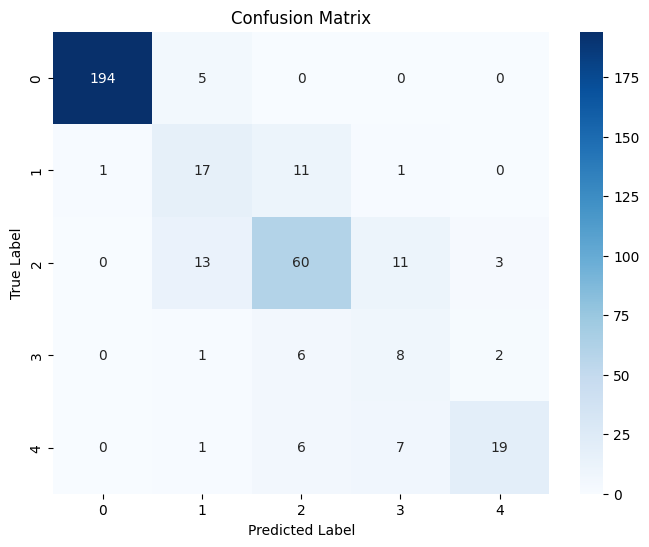

In [5]:
import torch
import numpy as np
import pandas as pd
import cv2  # The library is imported as cv2
import os
import timm
from tqdm.auto import tqdm
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================================
# REUSED CLASSES AND FUNCTIONS
# =============================================================================

class CFG:
    # Set these to match your final successful training run
    MODEL_NAME = 'efficientnet_b3'
    IMG_SIZE = 384
    
    # CORRECTED Paths to your test data
    BASE_PATH = "/kaggle/input/aptos2019"
    TEST_CSV = os.path.join(BASE_PATH, "test.csv")
    TEST_DIR = os.path.join(BASE_PATH, "test_images", "test_images")
    
    # Path to your saved model
    MODEL_PATH = "best_model_final.pth"
    
    BATCH_SIZE = 16 
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model Class ---
class EfficientNetOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=False):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes - 1)
        )
    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)

# --- Preprocessing and Dataset ---
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

def preprocess_ben_graham(image_np, output_size):
    try:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY) # FIXED: cv2
        if gray.mean() < 15:
             return cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA) # FIXED: cv2
        _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY) # FIXED: cv2
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIXED: cv2
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour) # FIXED: cv2
            image_np = image_np[y:y+h, x:x+w]
    except Exception:
        pass
    image_resized = cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA) # FIXED: cv2
    b, g, r = cv2.split(image_resized) # FIXED: cv2
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) # FIXED: cv2
    g = clahe.apply(g)
    return cv2.merge((b, g, r)) # FIXED: cv2

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path) # FIXED: cv2
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # FIXED: cv2
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img, label

# --- Utility ---
def ordinal_to_class(outputs):
    probs = torch.sigmoid(outputs)
    return torch.sum(probs > 0.5, dim=1).long()


# =============================================================================
# TESTING FUNCTION
# =============================================================================
def test_model():
    print("--- Starting Final Model Evaluation ---")
    
    # 1. Load Data
    test_df = pd.read_csv(CFG.TEST_CSV)
    print(f"Test data loaded: {len(test_df)} samples from {CFG.TEST_CSV.split('/')[-1]}")
    
    # 2. Define Transforms (no augmentations for testing)
    test_transform = A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.IMG_SIZE)),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    # 3. Create Dataset and DataLoader
    test_dataset = DiabeticRetinopathyDataset(test_df, CFG.TEST_DIR, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    
    # 4. Load Model
    model = EfficientNetOrdinal(CFG.MODEL_NAME, pretrained=False).to(CFG.DEVICE)
    model.load_state_dict(torch.load(CFG.MODEL_PATH, map_location=CFG.DEVICE))
    model.eval()
    print(f"Model loaded from {CFG.MODEL_PATH}")
    
    # 5. Get Predictions
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Predicting on test set"):
            images = images.to(CFG.DEVICE)
            
            outputs = model(images)
            preds = ordinal_to_class(outputs)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # 6. Calculate and Display Metrics
    print("\n--- Final Test Results ---")
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    accuracy = accuracy_score(all_labels, all_preds)
    
    print(f"Quadratic Weighted Kappa: {qwk:.4f}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # 7. Detailed Report
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(5)]))
    
    # 8. Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# --- RUN THE EVALUATION ---
test_model()

----------------------

**SWIM V2**

In [3]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight

import timm

# =============================================================================
# CONFIGURATION FOR SWIN TRANSFORMER V2
# =============================================================================
class CFG:
    MODEL_NAME = 'swinv2_tiny_window8_256'
    IMG_SIZE = 256
    BATCH_SIZE = 16
    BASE_PATH = "/kaggle/input/aptos2019"
    TRAIN_CSV = os.path.join(BASE_PATH, "train_1.csv")
    VAL_CSV   = os.path.join(BASE_PATH, "valid.csv")
    TRAIN_DIR = os.path.join(BASE_PATH, "train_images", "train_images")
    VAL_DIR   = os.path.join(BASE_PATH, "val_images", "val_images")
    S1_EPOCHS = 15
    S1_LR = 5e-5
    S1_WEIGHT_DECAY = 0.05
    S1_USE_MIXUP = True
    S2_EPOCHS = 15
    S2_LR = 1e-5 
    S2_WEIGHT_DECAY = 0.05
    S2_USE_MIXUP = False
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2
    PATIENCE = 5
    SEED = 42
    LABEL_SMOOTHING = 0.05
    SAVE_PATH_S1 = "best_model_swin_stage1.pth"
    SAVE_PATH_FINAL = "best_model_swin_final.pth"

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG.SEED)

# =============================================================================
# PREPROCESSING & AUGMENTATIONS (Unchanged)
# =============================================================================
def preprocess_ben_graham(image_np, output_size):
    try:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15:
             return cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
        _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            image_np = image_np[y:y+h, x:x+w]
    except Exception:
        pass
    image_resized = cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image_resized)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g = clahe.apply(g)
    return cv2.merge((b, g, r))

def get_transforms(img_size):
    pre_transforms = A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    ])
    post_transforms = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    val_transforms = A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size)),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    return pre_transforms, post_transforms, val_transforms

# =============================================================================
# DATASET, LOSSES (Unchanged)
# =============================================================================
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, pre_transform=None, post_transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.pre_transform = pre_transform
        self.post_transform = post_transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.pre_transform:
            augmented = self.pre_transform(image=img)
            img = augmented['image']
        if self.post_transform:
            tensor_aug = self.post_transform(image=img)
            img = tensor_aug['image']
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img, label

class WeightedOrdinalFocalLoss(nn.Module):
    def __init__(self, num_classes=5, gamma=2.0, class_weights=None, label_smoothing=0.0):
        super().__init__()
        self.num_classes = num_classes
        self.gamma = gamma
        self.class_weights = class_weights
        self.label_smoothing = label_smoothing
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, outputs, targets):
        ordinal_targets = torch.zeros_like(outputs)
        for i, t in enumerate(targets):
            if t > 0:
                ordinal_targets[i, :t] = 1.0
        if self.label_smoothing > 0.0:
            ordinal_targets = ordinal_targets * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing
        bce = self.bce(outputs, ordinal_targets)
        if self.class_weights is not None:
            weights = self.class_weights[targets].view(-1, 1).expand(-1, outputs.shape[1])
            bce = bce * weights
        pt = torch.exp(-bce)
        focal = (1 - pt) ** self.gamma * bce
        return focal.mean()

class SmoothKappaLoss(nn.Module):
    def __init__(self, num_classes=5, eps=1e-7):
        super().__init__()
        self.num_classes = num_classes
        self.eps = eps
        W = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes):
                W[i,j] = ((i - j)**2) / ((num_classes - 1)**2)
        self.register_buffer("W", W)
    def forward(self, outputs, targets):
        device = outputs.device
        B = outputs.size(0)
        probs = torch.sigmoid(outputs)
        class_probs = torch.zeros(B, self.num_classes, device=device)
        class_probs[:, 0] = 1 - probs[:, 0]
        for k in range(1, self.num_classes-1):
            class_probs[:, k] = probs[:, k-1] - probs[:, k]
        class_probs[:, -1] = probs[:, -1]
        class_probs = torch.clamp(class_probs, min=self.eps, max=1.0)
        one_hot = F.one_hot(targets, num_classes=self.num_classes).float().to(device)
        conf_mat = torch.matmul(one_hot.T, class_probs)
        hist_true = one_hot.sum(dim=0)
        hist_pred = class_probs.sum(dim=0)
        expected = torch.outer(hist_true, hist_pred)
        W = self.W.to(device)
        obs = torch.sum(W * conf_mat)
        exp = torch.sum(W * expected)
        kappa = 1.0 - (B * obs) / (exp + self.eps)
        return 1.0 - kappa

# =============================================================================
# CORRECTED SWIN TRANSFORMER MODEL CLASS
# =============================================================================
class SwinOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=True):
        super().__init__()
        # THE FIX IS HERE: added global_pool='avg'
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=0, 
            global_pool='avg' 
        )
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes - 1)
        )
    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)

# =============================================================================
# UTILITIES & TRAINING LOOPS (Unchanged)
# =============================================================================
def ordinal_to_class(outputs):
    probs = torch.sigmoid(outputs)
    return torch.sum(probs > 0.5, dim=1).long()

def calculate_metrics(outputs, targets):
    preds = ordinal_to_class(outputs).cpu().numpy()
    targets_np = targets.cpu().numpy()
    acc = accuracy_score(targets_np, preds)
    qwk = cohen_kappa_score(targets_np, preds, weights='quadratic')
    return acc, qwk

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def mixup_data(x, y, alpha=0.4):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_epoch(model, loader, optimizer, criterion, scaler, device, use_mixup):
    model.train()
    running_loss = 0.0
    all_out, all_t = [], []
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, targets in pbar:
        images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if use_mixup: images, targets_a, targets_b, lam = mixup_data(images, targets)
        with torch.cuda.amp.autocast():
            outputs = model(images)
            if use_mixup: loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else: loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        all_out.append(outputs.detach())
        all_t.append(targets.detach())
        pbar.set_postfix(loss=loss.item())
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_out, all_t = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, targets in pbar:
            images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, targets)
            running_loss += loss.item()
            all_out.append(outputs)
            all_t.append(targets)
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

# =============================================================================
# MAIN TRAINING PIPELINE
# =============================================================================
def main():
    print(f"Device: {CFG.DEVICE}, Model: {CFG.MODEL_NAME}, Image Size: {CFG.IMG_SIZE}")
    train_df = pd.read_csv(CFG.TRAIN_CSV)
    val_df = pd.read_csv(CFG.VAL_CSV)

    pre_tf, post_tf, val_tf = get_transforms(CFG.IMG_SIZE)

    train_ds = DiabeticRetinopathyDataset(train_df, CFG.TRAIN_DIR, pre_transform=pre_tf, post_transform=post_tf)
    val_ds   = DiabeticRetinopathyDataset(val_df, CFG.VAL_DIR, pre_transform=val_tf)

    class_weights_sampler = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
    sample_weights = np.array([class_weights_sampler[int(l)] for l in train_df['diagnosis']])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, sampler=sampler, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE*2, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)

    model = SwinOrdinal(CFG.MODEL_NAME, num_classes=5).to(CFG.DEVICE)
    
    class_weights_loss = torch.tensor(class_weights_sampler, dtype=torch.float).to(CFG.DEVICE)
    focal_loss = WeightedOrdinalFocalLoss(num_classes=5, gamma=2.0, class_weights=class_weights_loss, label_smoothing=CFG.LABEL_SMOOTHING)
    kappa_loss = SmoothKappaLoss(num_classes=5)
    
    def hybrid_loss(outputs, targets):
        return 0.7 * kappa_loss(outputs, targets) + 0.3 * focal_loss(outputs, targets)
    
    scaler = torch.cuda.amp.GradScaler()

    # --- STAGE 1: WEIGHTED FOCAL LOSS ---
    print("\n" + "="*50 + "\n     STARTING STAGE 1: WEIGHTED FOCAL LOSS\n" + "="*50)
    opt = optim.AdamW(model.parameters(), lr=CFG.S1_LR, weight_decay=CFG.S1_WEIGHT_DECAY)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S1_EPOCHS)
    best_val_qwk, patience_counter = -1, 0

    for epoch in range(CFG.S1_EPOCHS):
        clear_memory()
        print(f"\nEpoch {epoch+1}/{CFG.S1_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, focal_loss, scaler, CFG.DEVICE, CFG.S1_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, focal_loss, CFG.DEVICE)
        sched.step()
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, QWK: {train_qwk:.4f}")
        print(f"Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, QWK: {val_qwk:.4f}")
        if val_qwk > best_val_qwk:
            print(f"Val QWK improved from {best_val_qwk:.4f} to {val_qwk:.4f}. Saving model...")
            best_val_qwk, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), CFG.SAVE_PATH_S1)
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: print("Early stopping in Stage 1."); break
    
    # --- STAGE 2: HYBRID LOSS FINE-TUNING ---
    print("\n" + "="*50 + "\n     STARTING STAGE 2: HYBRID LOSS FINE-TUNING\n" + "="*50)
    model.load_state_dict(torch.load(CFG.SAVE_PATH_S1))
    opt = optim.AdamW(model.parameters(), lr=CFG.S2_LR, weight_decay=CFG.S2_WEIGHT_DECAY)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S2_EPOCHS)
    best_val_qwk_stage2, patience_counter = best_val_qwk, 0

    for epoch in range(CFG.S2_EPOCHS):
        clear_memory()
        print(f"\nEpoch {epoch+1}/{CFG.S2_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, hybrid_loss, scaler, CFG.DEVICE, CFG.S2_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, hybrid_loss, CFG.DEVICE)
        sched.step()
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, QWK: {train_qwk:.4f}")
        print(f"Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, QWK: {val_qwk:.4f}")
        if val_qwk > best_val_qwk_stage2:
            print(f"Val QWK improved from {best_val_qwk_stage2:.4f} to {val_qwk:.4f}. Saving final model...")
            best_val_qwk_stage2, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), CFG.SAVE_PATH_FINAL)
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: print("Early stopping in Stage 2."); break

    print(f"\nTraining Finished!\nBest Stage 1 QWK: {best_val_qwk:.4f}\nFinal Best QWK: {best_val_qwk_stage2:.4f}")

if __name__ == "__main__":
    main()

Device: cuda, Model: swinv2_tiny_window8_256, Image Size: 256


/tmp/ipykernel_36/218312670.py:85: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size)),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_36/218312670.py:97: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size)),



     STARTING STAGE 1: WEIGHTED FOCAL LOSS

Epoch 1/15


/tmp/ipykernel_36/218312670.py:303: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.4184, Acc: 0.2502, QWK: 0.3046
Valid -> Loss: 0.1634, Acc: 0.1831, QWK: 0.6888
Val QWK improved from -1.0000 to 0.6888. Saving model...

Epoch 2/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.3689, Acc: 0.3085, QWK: 0.3123
Valid -> Loss: 0.1558, Acc: 0.1803, QWK: 0.6726

Epoch 3/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.3289, Acc: 0.3433, QWK: 0.4021
Valid -> Loss: 0.1575, Acc: 0.1831, QWK: 0.6685

Epoch 4/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.3249, Acc: 0.3413, QWK: 0.4119
Valid -> Loss: 0.1355, Acc: 0.2077, QWK: 0.6624

Epoch 5/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.3127, Acc: 0.3573, QWK: 0.3810
Valid -> Loss: 0.1329, Acc: 0.2240, QWK: 0.6691

Epoch 6/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2713, Acc: 0.3840, QWK: 0.4373
Valid -> Loss: 0.1204, Acc: 0.2213, QWK: 0.6537
Early stopping in Stage 1.

     STARTING STAGE 2: HYBRID LOSS FINE-TUNING

Epoch 1/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.3094, Acc: 0.5420, QWK: 0.8218
Valid -> Loss: 0.2002, Acc: 0.6393, QWK: 0.8656
Val QWK improved from 0.6888 to 0.8656. Saving final model...

Epoch 2/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2531, Acc: 0.6201, QWK: 0.8677
Valid -> Loss: 0.2094, Acc: 0.6175, QWK: 0.8647

Epoch 3/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2174, Acc: 0.6693, QWK: 0.8916
Valid -> Loss: 0.1783, Acc: 0.6776, QWK: 0.8775
Val QWK improved from 0.8656 to 0.8775. Saving final model...

Epoch 4/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.2202, Acc: 0.6850, QWK: 0.8868
Valid -> Loss: 0.1645, Acc: 0.6995, QWK: 0.8936
Val QWK improved from 0.8775 to 0.8936. Saving final model...

Epoch 5/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1998, Acc: 0.6850, QWK: 0.8957
Valid -> Loss: 0.1549, Acc: 0.7022, QWK: 0.8986
Val QWK improved from 0.8936 to 0.8986. Saving final model...

Epoch 6/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1978, Acc: 0.6857, QWK: 0.8988
Valid -> Loss: 0.1487, Acc: 0.7022, QWK: 0.8943

Epoch 7/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1767, Acc: 0.7140, QWK: 0.9092
Valid -> Loss: 0.1637, Acc: 0.6967, QWK: 0.8870

Epoch 8/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1657, Acc: 0.7331, QWK: 0.9148
Valid -> Loss: 0.1531, Acc: 0.7104, QWK: 0.9001
Val QWK improved from 0.8986 to 0.9001. Saving final model...

Epoch 9/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1604, Acc: 0.7430, QWK: 0.9203
Valid -> Loss: 0.1465, Acc: 0.7131, QWK: 0.8998

Epoch 10/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1463, Acc: 0.7594, QWK: 0.9304
Valid -> Loss: 0.1424, Acc: 0.7158, QWK: 0.9015
Val QWK improved from 0.9001 to 0.9015. Saving final model...

Epoch 11/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1578, Acc: 0.7440, QWK: 0.9198
Valid -> Loss: 0.1425, Acc: 0.7158, QWK: 0.9038
Val QWK improved from 0.9015 to 0.9038. Saving final model...

Epoch 12/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1445, Acc: 0.7536, QWK: 0.9268
Valid -> Loss: 0.1388, Acc: 0.7268, QWK: 0.9039
Val QWK improved from 0.9038 to 0.9039. Saving final model...

Epoch 13/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1432, Acc: 0.7621, QWK: 0.9309
Valid -> Loss: 0.1392, Acc: 0.7131, QWK: 0.9042
Val QWK improved from 0.9039 to 0.9042. Saving final model...

Epoch 14/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1433, Acc: 0.7509, QWK: 0.9241
Valid -> Loss: 0.1399, Acc: 0.7131, QWK: 0.9001

Epoch 15/15


Training:   0%|          | 0/184 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_36/218312670.py:265: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss: 0.1410, Acc: 0.7515, QWK: 0.9280
Valid -> Loss: 0.1413, Acc: 0.7158, QWK: 0.9012

Training Finished!
Best Stage 1 QWK: 0.6888
Final Best QWK: 0.9042


--- Starting Final Model Evaluation for Swin Transformer ---
Test data loaded: 366 samples from test.csv


/tmp/ipykernel_36/1099717778.py:115: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.IMG_SIZE)),


Model loaded from best_model_swin_final.pth


Predicting on test set:   0%|          | 0/23 [00:00<?, ?it/s]


--- Final Test Results (Swin Transformer) ---
Quadratic Weighted Kappa: 0.9045
Accuracy: 0.7295 (72.95%)

--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98       199
     Class 1       0.38      0.77      0.51        30
     Class 2       0.77      0.28      0.41        87
     Class 3       0.20      0.71      0.31        17
     Class 4       0.75      0.45      0.57        33

    accuracy                           0.73       366
   macro avg       0.62      0.63      0.55       366
weighted avg       0.83      0.73      0.74       366


--- Confusion Matrix ---


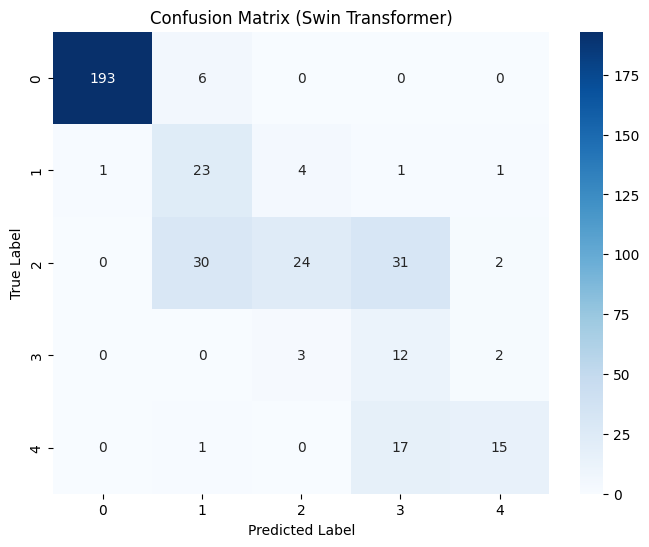

In [4]:
import torch
import numpy as np
import pandas as pd
import cv2
import os
import timm
from tqdm.auto import tqdm
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================================
# REUSED CLASSES AND FUNCTIONS
# =============================================================================

class CFG:
    # --- CONFIGURATION FOR THE SWIN TRANSFORMER YOU JUST TRAINED ---
    MODEL_NAME = 'swinv2_tiny_window8_256'
    IMG_SIZE = 256
    
    # --- PATHS TO YOUR TEST DATA ---
    BASE_PATH = "/kaggle/input/aptos2019"
    TEST_CSV = os.path.join(BASE_PATH, "test.csv")
    TEST_DIR = os.path.join(BASE_PATH, "test_images", "test_images")
    
    # --- PATH TO YOUR SAVED SWIN MODEL ---
    MODEL_PATH = "best_model_swin_final.pth"
    
    # --- INFERENCE CONFIGURATION ---
    BATCH_SIZE = 16 
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2

# --- Model Class (Must match the trained model) ---
class SwinOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=False):
        super().__init__()
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=0, 
            global_pool='avg'
        )
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes - 1)
        )
    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)

# --- Preprocessing and Dataset (Must match the trained model) ---
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

def preprocess_ben_graham(image_np, output_size):
    try:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15:
             return cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
        _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            image_np = image_np[y:y+h, x:x+w]
    except Exception:
        pass
    image_resized = cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image_resized)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g = clahe.apply(g)
    return cv2.merge((b, g, r))

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img, label

# --- Utility ---
def ordinal_to_class(outputs):
    probs = torch.sigmoid(outputs)
    return torch.sum(probs > 0.5, dim=1).long()


# =============================================================================
# TESTING FUNCTION
# =============================================================================
def test_model():
    print("--- Starting Final Model Evaluation for Swin Transformer ---")
    
    # 1. Load Data
    test_df = pd.read_csv(CFG.TEST_CSV)
    print(f"Test data loaded: {len(test_df)} samples from {CFG.TEST_CSV.split('/')[-1]}")
    
    # 2. Define Transforms (no augmentations for testing)
    test_transform = A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.IMG_SIZE)),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    # 3. Create Dataset and DataLoader
    test_dataset = DiabeticRetinopathyDataset(test_df, CFG.TEST_DIR, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    
    # 4. Load Model
    model = SwinOrdinal(CFG.MODEL_NAME, pretrained=False).to(CFG.DEVICE)
    model.load_state_dict(torch.load(CFG.MODEL_PATH, map_location=CFG.DEVICE))
    model.eval()
    print(f"Model loaded from {CFG.MODEL_PATH}")
    
    # 5. Get Predictions
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Predicting on test set"):
            images = images.to(CFG.DEVICE)
            
            outputs = model(images)
            preds = ordinal_to_class(outputs)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # 6. Calculate and Display Metrics
    print("\n--- Final Test Results (Swin Transformer) ---")
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    accuracy = accuracy_score(all_labels, all_preds)
    
    print(f"Quadratic Weighted Kappa: {qwk:.4f}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # 7. Detailed Report
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(5)]))
    
    # 8. Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Swin Transformer)")
    plt.show()

# --- RUN THE EVALUATION ---
test_model()

Model loaded successfully from best_model_swin_final.pth

--- Step 1: Evaluating on Validation Set to find thresholds ---


/tmp/ipykernel_36/1045962344.py:107: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.IMG_SIZE)),


Getting Validation Outputs:   0%|          | 0/23 [00:00<?, ?it/s]


--- Step 2: Optimizing Thresholds ---
Finding optimal thresholds...
Optimal thresholds found: [0.5947 0.1133 0.7584 0.5467]

--- Step 3: Evaluating on Test Set with new thresholds ---


Getting Test Outputs:   0%|          | 0/23 [00:00<?, ?it/s]


                 FINAL RESULTS COMPARISON

Original Score (Threshold = 0.5):
  QWK: 0.9045
  Accuracy: 72.95%

Polished Score (Optimized Thresholds):
  QWK: 0.9143
  Accuracy: 77.32%

--- Polished Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98       199
     Class 1       0.45      0.63      0.53        30
     Class 2       0.75      0.52      0.61        87
     Class 3       0.23      0.71      0.35        17
     Class 4       0.78      0.42      0.55        33

    accuracy                           0.77       366
   macro avg       0.64      0.65      0.60       366
weighted avg       0.84      0.77      0.79       366


--- Polished Confusion Matrix ---


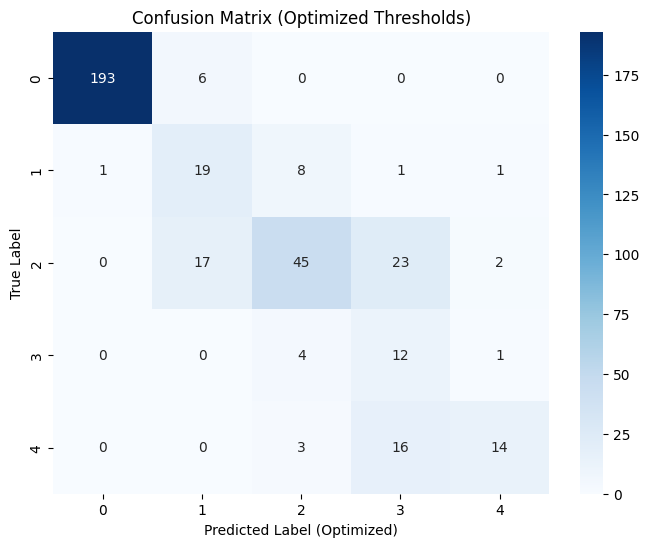

In [6]:
import torch
import numpy as np
import pandas as pd
import cv2
import os
import timm
from tqdm.auto import tqdm
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from scipy.optimize import minimize

# =============================================================================
# CONFIGURATION
# =============================================================================
class CFG:
    MODEL_NAME = 'swinv2_tiny_window8_256'
    IMG_SIZE = 256
    BASE_PATH = "/kaggle/input/aptos2019"
    
    # We need paths for both validation (to find thresholds) and test (for final score)
    VAL_CSV = os.path.join(BASE_PATH, "valid.csv")
    VAL_DIR = os.path.join(BASE_PATH, "val_images", "val_images")
    TEST_CSV = os.path.join(BASE_PATH, "test.csv")
    TEST_DIR = os.path.join(BASE_PATH, "test_images", "test_images")
    
    MODEL_PATH = "best_model_swin_final.pth"
    BATCH_SIZE = 16 
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2

# =============================================================================
# REUSED CLASSES & PREPROCESSING (Unchanged)
# =============================================================================
class SwinOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=False):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_classes - 1))
    def forward(self, x): return self.classifier(self.backbone(x))

def preprocess_ben_graham(image_np, output_size):
    try:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: return cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
        _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            image_np = image_np[y:y+h, x:x+w]
    except Exception: pass
    image_resized = cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image_resized); clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)); g = clahe.apply(g)
    return cv2.merge((b, g, r))

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df, self.img_dir, self.transform = df.reset_index(drop=True), img_dir, transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform: img = self.transform(image=img)['image']
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img, label

# =============================================================================
# OPTIMIZATION FUNCTIONS
# =============================================================================
def ordinal_to_class_with_thresholds(outputs, thresholds):
    probs = torch.sigmoid(outputs).cpu().numpy()
    preds = np.sum(probs > thresholds, axis=1)
    return preds

def kappa_objective(thresholds, outputs, targets):
    preds = ordinal_to_class_with_thresholds(outputs, thresholds)
    return -cohen_kappa_score(targets, preds, weights="quadratic")

def find_best_thresholds(outputs, targets):
    print("Finding optimal thresholds...")
    outputs = outputs.detach()
    targets = targets.cpu().numpy()
    init_thresh = np.array([0.5, 0.5, 0.5, 0.5])
    bounds = [(0.1, 0.9)] * len(init_thresh)
    res = minimize(kappa_objective, init_thresh, args=(outputs, targets), method="Powell", bounds=bounds)
    best_thresholds = res.x
    print(f"Optimal thresholds found: {np.round(best_thresholds, 4)}")
    return best_thresholds

# =============================================================================
# MAIN SCRIPT
# =============================================================================
def run_optimization_and_test():
    # --- Step 0: Load Model ---
    model = SwinOrdinal(CFG.MODEL_NAME, pretrained=False).to(CFG.DEVICE)
    model.load_state_dict(torch.load(CFG.MODEL_PATH, map_location=CFG.DEVICE))
    model.eval()
    print(f"Model loaded successfully from {CFG.MODEL_PATH}")

    transform = A.Compose([
        A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, CFG.IMG_SIZE)),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    # --- Step 1: Get Raw Answers on the Validation Set ---
    print("\n--- Step 1: Evaluating on Validation Set to find thresholds ---")
    val_df = pd.read_csv(CFG.VAL_CSV)
    val_dataset = DiabeticRetinopathyDataset(val_df, CFG.VAL_DIR, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
    
    val_outputs_list, val_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Getting Validation Outputs"):
            images = images.to(CFG.DEVICE)
            outputs = model(images)
            val_outputs_list.append(outputs.cpu())
            val_labels_list.append(labels)
    val_outputs = torch.cat(val_outputs_list)
    val_labels = torch.cat(val_labels_list)
    
    # --- Step 2: Find the Perfect "Grading Scale" ---
    print("\n--- Step 2: Optimizing Thresholds ---")
    best_thresholds = find_best_thresholds(val_outputs, val_labels)

    # --- Step 3: Use the Grading Scale on the Test Set ---
    print("\n--- Step 3: Evaluating on Test Set with new thresholds ---")
    test_df = pd.read_csv(CFG.TEST_CSV)
    test_dataset = DiabeticRetinopathyDataset(test_df, CFG.TEST_DIR, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

    test_outputs_list, test_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Getting Test Outputs"):
            images = images.to(CFG.DEVICE)
            outputs = model(images)
            test_outputs_list.append(outputs.cpu())
            test_labels_list.append(labels)
    test_outputs = torch.cat(test_outputs_list)
    test_labels = torch.cat(test_labels_list).numpy()
    
    # --- FINAL RESULTS ---
    print("\n" + "="*50)
    print("                 FINAL RESULTS COMPARISON")
    print("="*50)

    # Score with OLD simple 0.5 threshold
    preds_old = torch.sum(torch.sigmoid(test_outputs) > 0.5, dim=1).numpy()
    qwk_old = cohen_kappa_score(test_labels, preds_old, weights='quadratic')
    acc_old = accuracy_score(test_labels, preds_old)
    print(f"\nOriginal Score (Threshold = 0.5):")
    print(f"  QWK: {qwk_old:.4f}")
    print(f"  Accuracy: {acc_old*100:.2f}%")

    # Score with NEW optimized thresholds
    preds_new = ordinal_to_class_with_thresholds(test_outputs, best_thresholds)
    qwk_new = cohen_kappa_score(test_labels, preds_new, weights='quadratic')
    acc_new = accuracy_score(test_labels, preds_new)
    print(f"\nPolished Score (Optimized Thresholds):")
    print(f"  QWK: {qwk_new:.4f}")
    print(f"  Accuracy: {acc_new*100:.2f}%")
    print("="*50)
    
    # --- NEW: DETAILED REPORT FOR POLISHED SCORE ---
    print("\n--- Polished Classification Report ---")
    print(classification_report(test_labels, preds_new, target_names=[f"Class {i}" for i in range(5)]))
    
    print("\n--- Polished Confusion Matrix ---")
    cm = confusion_matrix(test_labels, preds_new)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted Label (Optimized)")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Optimized Thresholds)")
    plt.show()
    
run_optimization_and_test()

In [ ]:
------------------ efficent net B4--------------------

In [ ]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight

import timm

# =============================================================================
# CONFIGURATION FOR A ROBUST EFFICIENTNET-B4 RUN
# =============================================================================
class CFG:
    # --- MODEL & IMAGE SIZE ---
    MODEL_NAME = 'efficientnet_b4' # The single, powerful upgrade
    IMG_SIZE = 384                 # The optimal size for this model family
    BATCH_SIZE = 8                 # Safe batch size for this large model

    # --- DATA PATHS (Unchanged) ---
    BASE_PATH = "/kaggle/input/aptos2019"
    TRAIN_CSV = os.path.join(BASE_PATH, "train_1.csv")
    VAL_CSV   = os.path.join(BASE_PATH, "valid.csv")
    TRAIN_DIR = os.path.join(BASE_PATH, "train_images", "train_images")
    VAL_DIR   = os.path.join(BASE_PATH, "val_images", "val_images")
    
    # --- PROVEN, STABLE TRAINING STRATEGY ---
    # Stage 1: Weighted Focal Loss Training
    S1_EPOCHS = 15
    S1_LR = 1e-4
    S1_USE_MIXUP = True
    
    # Stage 2: Hybrid Loss Fine-tuning
    S2_EPOCHS = 15
    S2_LR = 3e-5 
    S2_USE_MIXUP = False
    
    # --- GENERAL & SAVING ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2
    PATIENCE = 5
    SEED = 42
    LABEL_SMOOTHING = 0.05
    # Save paths for this new model
    SAVE_PATH_S1 = "best_model_effnet_b4_stage1.pth"
    SAVE_PATH_FINAL = "best_model_effnet_b4_final.pth"

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG.SEED)

def preprocess_ben_graham(image_np, output_size):
    try:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: return cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
        _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            image_np = image_np[y:y+h, x:x+w]
    except Exception: pass
    image_resized = cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image_resized); clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)); g = clahe.apply(g)
    return cv2.merge((b, g, r))

def get_transforms(img_size):
    pre_transforms = A.Compose([A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size)), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7), A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7), A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5)])
    post_transforms = A.Compose([A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()])
    val_transforms = A.Compose([A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size)), A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()])
    return pre_transforms, post_transforms, val_transforms

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, pre_transform=None, post_transform=None):
        self.df, self.img_dir, self.pre_transform, self.post_transform = df.reset_index(drop=True), img_dir, pre_transform, post_transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.pre_transform: img = self.pre_transform(image=img)['image']
        if self.post_transform: img = self.post_transform(image=img)['image']
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img, label

class WeightedOrdinalFocalLoss(nn.Module):
    def __init__(self, num_classes=5, gamma=2.0, class_weights=None, label_smoothing=0.0):
        super().__init__()
        self.num_classes, self.gamma, self.class_weights, self.label_smoothing = num_classes, gamma, class_weights, label_smoothing
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, outputs, targets):
        ordinal_targets = torch.zeros_like(outputs)
        for i, t in enumerate(targets):
            if t > 0: ordinal_targets[i, :t] = 1.0
        if self.label_smoothing > 0.0: ordinal_targets = ordinal_targets * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing
        bce = self.bce(outputs, ordinal_targets)
        if self.class_weights is not None:
            weights = self.class_weights[targets].view(-1, 1).expand(-1, outputs.shape[1])
            bce = bce * weights
        pt = torch.exp(-bce); focal = (1 - pt) ** self.gamma * bce
        return focal.mean()

class SmoothKappaLoss(nn.Module):
    def __init__(self, num_classes=5, eps=1e-7):
        super().__init__(); self.num_classes, self.eps = num_classes, eps
        W = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes): W[i,j] = ((i - j)**2) / ((num_classes - 1)**2)
        self.register_buffer("W", W)
    def forward(self, outputs, targets):
        device = outputs.device; B = outputs.size(0); probs = torch.sigmoid(outputs)
        class_probs = torch.zeros(B, self.num_classes, device=device)
        class_probs[:, 0] = 1 - probs[:, 0]
        for k in range(1, self.num_classes-1): class_probs[:, k] = probs[:, k-1] - probs[:, k]
        class_probs[:, -1] = probs[:, -1]
        class_probs = torch.clamp(class_probs, min=self.eps, max=1.0)
        one_hot = F.one_hot(targets, num_classes=self.num_classes).float().to(device)
        conf_mat = torch.matmul(one_hot.T, class_probs)
        hist_true = one_hot.sum(dim=0); hist_pred = class_probs.sum(dim=0)
        expected = torch.outer(hist_true, hist_pred)
        W = self.W.to(device); obs = torch.sum(W * conf_mat); exp = torch.sum(W * expected)
        kappa = 1.0 - (B * obs) / (exp + self.eps)
        return 1.0 - kappa

class EfficientNetOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_classes - 1))
    def forward(self, x): return self.classifier(self.backbone(x))

def mixup_data(x, y, alpha=0.4):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = x.size()[0]; index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]; y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def ordinal_to_class(outputs): return torch.sum(torch.sigmoid(outputs) > 0.5, dim=1).long()
def calculate_metrics(outputs, targets):
    preds = ordinal_to_class(outputs).cpu().numpy(); targets_np = targets.cpu().numpy()
    return accuracy_score(targets_np, preds), cohen_kappa_score(targets_np, preds, weights='quadratic')
def clear_memory(): gc.collect(); torch.cuda.empty_cache()

def train_epoch(model, loader, optimizer, criterion, scaler, device, use_mixup):
    model.train(); running_loss = 0.0; all_out, all_t = [], []
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, targets in pbar:
        images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if use_mixup: images, targets_a, targets_b, lam = mixup_data(images, targets)
        with torch.cuda.amp.autocast():
            outputs = model(images)
            if use_mixup: loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else: loss = criterion(outputs, targets)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        running_loss += loss.item(); all_out.append(outputs.detach()); all_t.append(targets.detach())
        pbar.set_postfix(loss=loss.item())
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def validate_epoch(model, loader, criterion, device):
    model.eval(); running_loss = 0.0; all_out, all_t = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, targets in pbar:
            images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, targets)
            running_loss += loss.item()
            all_out.append(outputs)
            all_t.append(targets)
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def main():
    print(f"Device: {CFG.DEVICE}, Model: {CFG.MODEL_NAME}, Image Size: {CFG.IMG_SIZE}")
    train_df = pd.read_csv(CFG.TRAIN_CSV); val_df = pd.read_csv(CFG.VAL_CSV)
    pre_tf, post_tf, val_tf = get_transforms(CFG.IMG_SIZE)
    train_ds = DiabeticRetinopathyDataset(train_df, CFG.TRAIN_DIR, pre_transform=pre_tf, post_transform=post_tf)
    val_ds = DiabeticRetinopathyDataset(val_df, CFG.VAL_DIR, pre_transform=val_tf)
    class_weights_sampler = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
    sample_weights = np.array([class_weights_sampler[int(l)] for l in train_df['diagnosis']])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, sampler=sampler, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE*2, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    
    model = EfficientNetOrdinal(CFG.MODEL_NAME).to(CFG.DEVICE)
    class_weights_loss = torch.tensor(class_weights_sampler, dtype=torch.float).to(CFG.DEVICE)
    focal_loss = WeightedOrdinalFocalLoss(num_classes=5, gamma=2.0, class_weights=class_weights_loss, label_smoothing=CFG.LABEL_SMOOTHING)
    kappa_loss = SmoothKappaLoss(num_classes=5)
    
    def hybrid_loss(outputs, targets):
        return 0.7 * kappa_loss(outputs, targets) + 0.3 * focal_loss(outputs, targets)
    
    scaler = torch.cuda.amp.GradScaler()

    # --- STAGE 1: WEIGHTED FOCAL LOSS ---
    print("\n" + "="*50 + "\n     STARTING STAGE 1: WEIGHTED FOCAL LOSS\n" + "="*50)
    opt = optim.AdamW(model.parameters(), lr=CFG.S1_LR, weight_decay=1e-4)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S1_EPOCHS)
    best_val_qwk, patience_counter = -1, 0

    for epoch in range(CFG.S1_EPOCHS):
        clear_memory(); print(f"\nEpoch {epoch+1}/{CFG.S1_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, focal_loss, scaler, CFG.DEVICE, CFG.S1_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, focal_loss, CFG.DEVICE)
        sched.step()
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, QWK: {train_qwk:.4f}")
        print(f"Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, QWK: {val_qwk:.4f}")
        if val_qwk > best_val_qwk:
            print(f"Val QWK improved from {best_val_qwk:.4f} to {val_qwk:.4f}. Saving model...")
            best_val_qwk, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), CFG.SAVE_PATH_S1)
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: print("Early stopping in Stage 1."); break
    
    # --- STAGE 2: HYBRID LOSS FINE-TUNING ---
    print("\n" + "="*50 + "\n     STARTING STAGE 2: HYBRID LOSS FINE-TUNING\n" + "="*50)
    model.load_state_dict(torch.load(CFG.SAVE_PATH_S1))
    opt = optim.AdamW(model.parameters(), lr=CFG.S2_LR, weight_decay=1e-5)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S2_EPOCHS)
    best_val_qwk_stage2, patience_counter = best_val_qwk, 0

    for epoch in range(CFG.S2_EPOCHS):
        clear_memory(); print(f"\nEpoch {epoch+1}/{CFG.S2_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, hybrid_loss, scaler, CFG.DEVICE, CFG.S2_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, hybrid_loss, CFG.DEVICE)
        sched.step()
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, QWK: {train_qwk:.4f}")
        print(f"Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, QWK: {val_qwk:.4f}")
        if val_qwk > best_val_qwk_stage2:
            print(f"Val QWK improved from {best_val_qwk_stage2:.4f} to {val_qwk:.4f}. Saving final model...")
            best_val_qwk_stage2, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), CFG.SAVE_PATH_FINAL)
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: print("Early stopping in Stage 2."); break

    print(f"\nTraining Finished!\nBest Stage 1 QWK: {best_val_qwk:.4f}\nFinal Best QWK: {best_val_qwk_stage2:.4f}")

if __name__ == "__main__":
    main()

Device: cuda, Model: efficientnet_b4, Image Size: 384


/tmp/ipykernel_1675/3562726915.py:81: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  pre_transforms = A.Compose([A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size)), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7), A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7), A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5)])
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_1675/3562726915.py:83: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  val_transforms = A.Compose([A.Lambda(image=lambda x, **kwargs: preprocess_ben


     STARTING UPGRADED TRAINING PIPELINE

Epoch 1/15


/tmp/ipykernel_1675/3562726915.py:182: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_1675/3562726915.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_1675/3562726915.py:209: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_1675/3562726915.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss: 0.6936, Acc: 0.2157, QWK: 0.0157
Valid -> Loss: 0.2700, Acc: 0.0601, QWK: 0.0000
Val QWK improved from -1.0000 to 0.0000. Saving final model...

Epoch 2/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_1675/3562726915.py:209: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_1675/3562726915.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_1675/3562726915.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss: 0.4408, Acc: 0.2618, QWK: 0.3002
Valid -> Loss: 0.1694, Acc: 0.1858, QWK: 0.6413
Val QWK improved from 0.0000 to 0.6413. Saving final model...

Epoch 3/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_1675/3562726915.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_1675/3562726915.py:209: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


--------------- test with diff optimizer if fails

In [ ]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight

import timm

# =============================================================================
# CONFIGURATION FOR A ROBUST EFFICIENTNET-B4 RUN
# =============================================================================
class CFG:
    # --- MODEL & IMAGE SIZE ---
    MODEL_NAME = 'efficientnet_b4' # The single, powerful upgrade
    IMG_SIZE = 384                 # The optimal size for this model family
    BATCH_SIZE = 8                 # Safe batch size for this large model

    # --- DATA PATHS (Unchanged) ---
    BASE_PATH = "/kaggle/input/aptos2019"
    TRAIN_CSV = os.path.join(BASE_PATH, "train_1.csv")
    VAL_CSV   = os.path.join(BASE_PATH, "valid.csv")
    TRAIN_DIR = os.path.join(BASE_PATH, "train_images", "train_images")
    VAL_DIR   = os.path.join(BASE_PATH, "val_images", "val_images")
    
    # --- PROVEN, STABLE TRAINING STRATEGY ---
    # Stage 1: Weighted Focal Loss Training
    S1_EPOCHS = 15
    S1_LR = 1e-4
    S1_USE_MIXUP = True
    
    # Stage 2: Hybrid Loss Fine-tuning
    S2_EPOCHS = 15
    S2_LR = 3e-5 
    S2_USE_MIXUP = False
    
    # --- GENERAL & SAVING ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2
    PATIENCE = 5
    SEED = 42
    LABEL_SMOOTHING = 0.05
    # Save paths for this new model
    SAVE_PATH_S1 = "best_model_effnet_b4_stage1.pth"
    SAVE_PATH_FINAL = "best_model_effnet_b4_final.pth"

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG.SEED)

def preprocess_ben_graham(image_np, output_size):
    try:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: return cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
        _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            image_np = image_np[y:y+h, x:x+w]
    except Exception: pass
    image_resized = cv2.resize(image_np, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image_resized); clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)); g = clahe.apply(g)
    return cv2.merge((b, g, r))

def get_transforms(img_size):
    pre_transforms = A.Compose([A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size)), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7), A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7), A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5)])
    post_transforms = A.Compose([A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()])
    val_transforms = A.Compose([A.Lambda(image=lambda x, **kwargs: preprocess_ben_graham(x, img_size)), A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()])
    return pre_transforms, post_transforms, val_transforms

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, df, img_dir, pre_transform=None, post_transform=None):
        self.df, self.img_dir, self.pre_transform, self.post_transform = df.reset_index(drop=True), img_dir, pre_transform, post_transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.pre_transform: img = self.pre_transform(image=img)['image']
        if self.post_transform: img = self.post_transform(image=img)['image']
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img, label

class WeightedOrdinalFocalLoss(nn.Module):
    def __init__(self, num_classes=5, gamma=2.0, class_weights=None, label_smoothing=0.0):
        super().__init__()
        self.num_classes, self.gamma, self.class_weights, self.label_smoothing = num_classes, gamma, class_weights, label_smoothing
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, outputs, targets):
        ordinal_targets = torch.zeros_like(outputs)
        for i, t in enumerate(targets):
            if t > 0: ordinal_targets[i, :t] = 1.0
        if self.label_smoothing > 0.0: ordinal_targets = ordinal_targets * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing
        bce = self.bce(outputs, ordinal_targets)
        if self.class_weights is not None:
            weights = self.class_weights[targets].view(-1, 1).expand(-1, outputs.shape[1])
            bce = bce * weights
        pt = torch.exp(-bce); focal = (1 - pt) ** self.gamma * bce
        return focal.mean()

class SmoothKappaLoss(nn.Module):
    def __init__(self, num_classes=5, eps=1e-7):
        super().__init__(); self.num_classes, self.eps = num_classes, eps
        W = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes): W[i,j] = ((i - j)**2) / ((num_classes - 1)**2)
        self.register_buffer("W", W)
    def forward(self, outputs, targets):
        device = outputs.device; B = outputs.size(0); probs = torch.sigmoid(outputs)
        class_probs = torch.zeros(B, self.num_classes, device=device)
        class_probs[:, 0] = 1 - probs[:, 0]
        for k in range(1, self.num_classes-1): class_probs[:, k] = probs[:, k-1] - probs[:, k]
        class_probs[:, -1] = probs[:, -1]
        class_probs = torch.clamp(class_probs, min=self.eps, max=1.0)
        one_hot = F.one_hot(targets, num_classes=self.num_classes).float().to(device)
        conf_mat = torch.matmul(one_hot.T, class_probs)
        hist_true = one_hot.sum(dim=0); hist_pred = class_probs.sum(dim=0)
        expected = torch.outer(hist_true, hist_pred)
        W = self.W.to(device); obs = torch.sum(W * conf_mat); exp = torch.sum(W * expected)
        kappa = 1.0 - (B * obs) / (exp + self.eps)
        return 1.0 - kappa

class EfficientNetOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_classes - 1))
    def forward(self, x): return self.classifier(self.backbone(x))

def mixup_data(x, y, alpha=0.4):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = x.size()[0]; index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]; y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def ordinal_to_class(outputs): return torch.sum(torch.sigmoid(outputs) > 0.5, dim=1).long()
def calculate_metrics(outputs, targets):
    preds = ordinal_to_class(outputs).cpu().numpy(); targets_np = targets.cpu().numpy()
    return accuracy_score(targets_np, preds), cohen_kappa_score(targets_np, preds, weights='quadratic')
def clear_memory(): gc.collect(); torch.cuda.empty_cache()

def train_epoch(model, loader, optimizer, criterion, scaler, device, use_mixup):
    model.train(); running_loss = 0.0; all_out, all_t = [], []
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, targets in pbar:
        images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if use_mixup: images, targets_a, targets_b, lam = mixup_data(images, targets)
        with torch.cuda.amp.autocast():
            outputs = model(images)
            if use_mixup: loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else: loss = criterion(outputs, targets)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        running_loss += loss.item(); all_out.append(outputs.detach()); all_t.append(targets.detach())
        pbar.set_postfix(loss=loss.item())
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def validate_epoch(model, loader, criterion, device):
    model.eval(); running_loss = 0.0; all_out, all_t = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, targets in pbar:
            images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, targets)
            running_loss += loss.item()
            all_out.append(outputs)
            all_t.append(targets)
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def main():
    print(f"Device: {CFG.DEVICE}, Model: {CFG.MODEL_NAME}, Image Size: {CFG.IMG_SIZE}")
    train_df = pd.read_csv(CFG.TRAIN_CSV); val_df = pd.read_csv(CFG.VAL_CSV)
    pre_tf, post_tf, val_tf = get_transforms(CFG.IMG_SIZE)
    train_ds = DiabeticRetinopathyDataset(train_df, CFG.TRAIN_DIR, pre_transform=pre_tf, post_transform=post_tf)
    val_ds = DiabeticRetinopathyDataset(val_df, CFG.VAL_DIR, pre_transform=val_tf)
    class_weights_sampler = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
    sample_weights = np.array([class_weights_sampler[int(l)] for l in train_df['diagnosis']])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, sampler=sampler, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE*2, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    
    model = EfficientNetOrdinal(CFG.MODEL_NAME).to(CFG.DEVICE)
    class_weights_loss = torch.tensor(class_weights_sampler, dtype=torch.float).to(CFG.DEVICE)
    focal_loss = WeightedOrdinalFocalLoss(num_classes=5, gamma=2.0, class_weights=class_weights_loss, label_smoothing=CFG.LABEL_SMOOTHING)
    kappa_loss = SmoothKappaLoss(num_classes=5)
    
    def hybrid_loss(outputs, targets):
        return 0.7 * kappa_loss(outputs, targets) + 0.3 * focal_loss(outputs, targets)
    
    scaler = torch.cuda.amp.GradScaler()

    # --- STAGE 1: WEIGHTED FOCAL LOSS ---
    print("\n" + "="*50 + "\n     STARTING STAGE 1: WEIGHTED FOCAL LOSS\n" + "="*50)
    opt = optim.AdamW(model.parameters(), lr=CFG.S1_LR, weight_decay=1e-4)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S1_EPOCHS)
    best_val_qwk, patience_counter = -1, 0

    for epoch in range(CFG.S1_EPOCHS):
        clear_memory(); print(f"\nEpoch {epoch+1}/{CFG.S1_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, focal_loss, scaler, CFG.DEVICE, CFG.S1_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, focal_loss, CFG.DEVICE)
        sched.step()
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, QWK: {train_qwk:.4f}")
        print(f"Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, QWK: {val_qwk:.4f}")
        if val_qwk > best_val_qwk:
            print(f"Val QWK improved from {best_val_qwk:.4f} to {val_qwk:.4f}. Saving model...")
            best_val_qwk, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), CFG.SAVE_PATH_S1)
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: print("Early stopping in Stage 1."); break
    
    # --- STAGE 2: HYBRID LOSS FINE-TUNING ---
    print("\n" + "="*50 + "\n     STARTING STAGE 2: HYBRID LOSS FINE-TUNING\n" + "="*50)
    model.load_state_dict(torch.load(CFG.SAVE_PATH_S1))
    opt = optim.AdamW(model.parameters(), lr=CFG.S2_LR, weight_decay=1e-5)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S2_EPOCHS)
    best_val_qwk_stage2, patience_counter = best_val_qwk, 0

    for epoch in range(CFG.S2_EPOCHS):
        clear_memory(); print(f"\nEpoch {epoch+1}/{CFG.S2_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, hybrid_loss, scaler, CFG.DEVICE, CFG.S2_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, hybrid_loss, CFG.DEVICE)
        sched.step()
        print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, QWK: {train_qwk:.4f}")
        print(f"Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, QWK: {val_qwk:.4f}")
        if val_qwk > best_val_qwk_stage2:
            print(f"Val QWK improved from {best_val_qwk_stage2:.4f} to {val_qwk:.4f}. Saving final model...")
            best_val_qwk_stage2, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), CFG.SAVE_PATH_FINAL)
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: print("Early stopping in Stage 2."); break

    print(f"\nTraining Finished!\nBest Stage 1 QWK: {best_val_qwk:.4f}\nFinal Best QWK: {best_val_qwk_stage2:.4f}")

if __name__ == "__main__":
    main()